<a href="https://colab.research.google.com/github/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/blob/main/Model_catboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import Libraries

In [ ]:
import numpy as np  
import pandas as pd  
import datetime as dt

# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, log_loss, f1_score, precision_score, recall_score, plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report


from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score, mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.utils import compute_class_weight
from sklearn.metrics import plot_roc_curve


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from google.colab import drive


https://medium.com/analytics-vidhya/predictive-modeling-for-tanzanian-water-pumps-701bcc7760b2

https://towardsdatascience.com/predicting-the-functional-status-of-pumps-in-tanzania-355c9269d0c2

https://rstudio-pubs-static.s3.amazonaws.com/339668_006f4906390e41cea23b3b786cc0230a.html

https://itnext.io/predicting-functional-water-pumps-in-tanzania-using-random-forests-and-logistic-regression-in-ffa04b0617f2

https://towardsdatascience.com/pump-it-up-with-catboost-828bf9eaac68

### Check Allocated System Specs by Google Colab

In [ ]:
from psutil import *

cpu_count()

2

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!df -h / |awk '{print $4}'

Avail
85G


In [ ]:
!free -h  --si | awk '/Mem:/{print $2}'

13G


In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)
    
     # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

#1. Loading the dataset from GitHub: [MMAI869-Pump-it-Up-Competition]

  Data is accessed from github: (https://github.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition)



In [ ]:
ulr_Training_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Values.csv'
ulr_Training_Set_Labels = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Training_Set_Labels.csv'
ulr_Test_Set_Values = 'https://raw.githubusercontent.com/AmiraliLalehpour/MMAI869-Pump-it-Up-Competition/main/Test_Set_Values.csv'
Training_Set_Values = pd.read_csv(ulr_Training_Set_Values)
Training_Set_Labels = pd.read_csv(ulr_Training_Set_Labels)
test = pd.read_csv(ulr_Test_Set_Values)
data = Training_Set_Values.merge(Training_Set_Labels, on='id', how='right')

In [ ]:
test_id = pd.read_csv(ulr_Test_Set_Values).id
original_data = data

#2- Data Cleaning and Imputation

##2.1- Numerical Features
Some of the numerical features are actally categorical, since they get only certain values relating to a specific region, such as:
1.   region_code
2.   district_code

We will consider these in categorical features. Also the year constructed is a date&Time feature.

In [ ]:
df_numerical_features = data.select_dtypes(exclude='object')
df_numerical_features.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

* For the Na values, decided to use the most frequent value instead

In [ ]:
data = data.drop(['num_private'], axis=1)
test = test.drop(['num_private'], axis=1)

###2.1.4- population
Population around the well.

We will use KNN to predict the value of Nan.

In [ ]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,1069.831684,35.145285,-5.863834,15.297003,5.629747,233.902407,1997.925202
std,21453.128371,2997.574558,501.077319,2.567468,2.769398,17.587406,9.633649,456.126443,10.179591
min,0.000000,0.000000,-90.000000,29.607000,-11.649000,1.000000,0.000000,1.000000,1960.000000
25%,18519.750000,0.000000,903.000000,33.354000,-8.540250,5.000000,2.000000,100.000000,1996.000000
50%,37061.500000,0.000000,1167.000000,35.006000,-5.173000,12.000000,3.000000,150.000000,2000.000000
75%,55656.500000,20.000000,1319.250000,37.178000,-3.398000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345000,-0.998000,99.000000,80.000000,30500.000000,2013.000000


In [ ]:
col_name = ['latitude', 'longitude', 'gps_height', 'construction_year', 'population']
for col in col_name: 
  zero_index = data[data[col] == 0 ].id.tolist()
  data.loc[data['id'].isin(zero_index), col]= np.NaN
  data[col]= data[col].fillna(data[col] .median())

  zero_index = test[test[col] == 0 ].id.tolist()
  test.loc[data['id'].isin(zero_index), col]= np.NaN
  test[col]= test[col].fillna(test[col] .median())

In [ ]:
df_categorical_features = data.select_dtypes(include='object')
df_categorical_features.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group'],
      dtype='object')

<ipython-input-22-34fe7e190da0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[column] = labelencoder.fit_transform(df_cat[column])


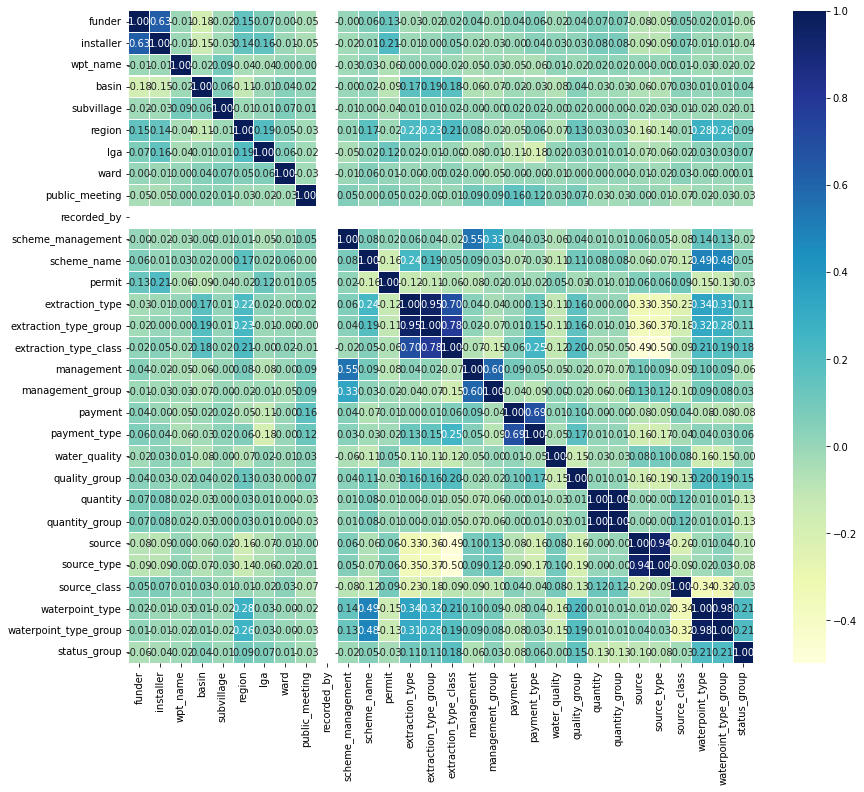

In [ ]:
from sklearn.preprocessing import LabelEncoder
cat_column = ['funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group']
df_cat = data[cat_column]
labelencoder=LabelEncoder()
for column in df_cat.columns:
    df_cat[column] = labelencoder.fit_transform(df_cat[column])

plt.figure(figsize=(14,12))
sns.heatmap(df_cat.corr(method='pearson'),linewidths=.1,cmap='YlGnBu', annot=True, fmt='.2f')
plt.yticks(rotation=0);

In [ ]:
from collections import Counter
import math
import scipy.stats as ss
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [ ]:

columns = ['amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'wpt_name', 
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group',  'original_population', 'new_lat', 'new_long']
theilu = pd.DataFrame(index=['status_group'],columns=columns)
for j in range(0,len(columns)):
    u = theil_u(data['status_group'].tolist(),data[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(30,1))
sns.set(font_scale=1.0)
sns.heatmap(theilu,annot=True, annot_kws={'size': 14},fmt='.2f')
plt.show()

KeyError: ignored

In [ ]:
data.ward = data.ward.str.lower()
test.ward = test.ward.str.lower()

In [ ]:
data.funder.fillna('Missing', inplace=True)
test.funder.fillna('Missing', inplace=True)
data.installer = data.installer.str.lower()
test.installer = data.installer.str.lower()
data.installer.fillna('Missing', inplace=True)
test.installer.fillna('Missing', inplace=True)

wpt_name_none_index = data[data.wpt_name=='none'].id.tolist()
data.loc[data['id'].isin(wpt_name_none_index), 'wpt_name']= np.NaN

wpt_name_test_none_index = test[test.wpt_name=='none'].id.tolist()
test.loc[test['id'].isin(wpt_name_test_none_index), 'wpt_name']= np.NaN

data.wpt_name.fillna('Missing', inplace=True)
test.wpt_name.fillna('Missing', inplace=True)

data.subvillage.fillna('Missing', inplace=True)
test.subvillage.fillna('Missing', inplace=True)
data.scheme_management.fillna('Missing', inplace=True)
test.scheme_management.fillna('Missing', inplace=True)

scheme_management_none_index = data[data.scheme_management=='None'].id.tolist()
data.loc[data['id'].isin(scheme_management_none_index), 'scheme_management']= 'Other'
data.scheme_name.fillna('Missing', inplace=True)
test.scheme_name.fillna('Missing', inplace=True)

data.scheme_name = data.scheme_name.str.lower()
test.scheme_name = data.scheme_name.str.lower()

In [ ]:
data.public_meeting.fillna('Missing', inplace=True)
test.public_meeting.fillna('Missing', inplace=True)
data.public_meeting = data.public_meeting.replace({True: 'Yes', False: 'No'})
test.public_meeting = test.public_meeting.replace({True: 'Yes', False: 'No'})
data.permit.fillna('Missing', inplace=True)
test.permit.fillna('Missing', inplace=True)
data.permit = data.permit.replace({True: 'Yes', False: 'No'})
test.permit = test.permit.replace({True: 'Yes', False: 'No'})

In [ ]:
data = data.drop(['recorded_by'], axis=1)
test = test.drop(['recorded_by'], axis=1)

In [ ]:
data.date_recorded = pd.to_datetime(data.date_recorded)
test.date_recorded = pd.to_datetime(test.date_recorded)

In [ ]:
data['year_recorded'] = data.date_recorded.dt.year
test['year_recorded'] = test.date_recorded.dt.year

data['month_recorded'] = data.date_recorded.dt.month
test['month_recorded'] = test.date_recorded.dt.month

data['day_recorded'] = data.date_recorded.dt.weekday
test['day_recorded'] = test.date_recorded.dt.weekday

data['quarer_recorded'] = data.date_recorded.dt.quarter
test['quarer_recorded'] = test.date_recorded.dt.quarter

data = data.drop(['date_recorded'],axis=1)
test = test.drop(['date_recorded'],axis=1)

In [ ]:
data['percipitation_class'] = data['month_recorded']
data['percipitation_class']=0
test['percipitation_class'] = test['month_recorded']
test['percipitation_class']=0

In [ ]:

data['percipitation_class'] = np.where((data['month_recorded'] == 1), 4, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 3), 4, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 12), 3, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 2), 2, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 4), 2, data['percipitation_class'])
data['percipitation_class'] = np.where((data['month_recorded'] == 11), 1, data['percipitation_class'])

In [ ]:
test['percipitation_class'] = np.where((test['month_recorded'] == 1), 4, test['percipitation_class'])
test['percipitation_class'] = np.where((test['month_recorded'] == 3), 4, test['percipitation_class'])
test['percipitation_class'] = np.where((test['month_recorded'] == 12), 3, test['percipitation_class'])
test['percipitation_class'] = np.where((test['month_recorded'] == 2), 2, test['percipitation_class'])
test['percipitation_class'] = np.where((test['month_recorded'] == 4), 2, test['percipitation_class'])
test['percipitation_class'] = np.where((test['month_recorded'] == 11), 1, test['percipitation_class'])

In [ ]:
print(round(20709/59400*100,1), 'of data for construction_year is missing')

34.9 of data for construction_year is missing


In [ ]:
pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from feature_engine.encoding import RareLabelEncoder
pd.set_option('display.max_columns', None)

In [ ]:
rare_encoder = RareLabelEncoder(
    tol=0.025,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['extraction_type',
               'extraction_type_group', 'extraction_type_class', 'management', 
               'management_group', 'payment', 'payment_type', 'water_quality',
               'quality_group', 'quantity', 'quantity_group', 'source', 
               'source_type', 'source_class', 'waterpoint_type',
               'waterpoint_type_group',
               'scheme_management'], # variables to re-group
    replace_with='Rare'
)  

In [ ]:
rare_encoder_EXtreme_Cardinality = RareLabelEncoder(
    tol=0.007,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    max_n_categories = 75,
    variables=['lga', 'funder', 'installer', 'wpt_name', 'subvillage', 'scheme_name'], # variables to re-group
    replace_with='Rare'
)  

In [ ]:
rare_encoder_ExCard_ward = RareLabelEncoder(
    tol=0.002,  # minimal percentage to be considered non-rare
    n_categories=4, # minimal number of categories the variable should have to re-cgroup rare categories
    max_n_categories = 75,
    variables=['ward'], # variables to re-group
    replace_with='Rare'
)

In [ ]:
main_data = data

In [ ]:
rare_encoder.fit(data.drop('status_group', axis=1))

/usr/local/lib/python3.8/dist-packages/feature_engine/encoding/rare_label.py:199: UserWarning: The number of unique categories for variable source_class is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


RareLabelEncoder(n_categories=4, tol=0.025,
                 variables=['extraction_type', 'extraction_type_group',
                            'extraction_type_class', 'management',
                            'management_group', 'payment', 'payment_type',
                            'water_quality', 'quality_group', 'quantity',
                            'quantity_group', 'source', 'source_type',
                            'source_class', 'waterpoint_type',
                            'waterpoint_type_group', 'scheme_management'])

In [ ]:
rare_encoder_EXtreme_Cardinality.fit(data.drop('status_group', axis=1))

RareLabelEncoder(max_n_categories=75, n_categories=4, tol=0.007,
                 variables=['lga', 'funder', 'installer', 'wpt_name',
                            'subvillage', 'scheme_name'])

In [ ]:
rare_encoder_ExCard_ward.fit(data.drop('status_group', axis=1))

RareLabelEncoder(max_n_categories=75, n_categories=4, tol=0.002,
                 variables=['ward'])

In [ ]:
data_imputed = rare_encoder.transform(data.drop('status_group', axis=1))
test_imputed = rare_encoder.transform(test)

In [ ]:
data_imputed = rare_encoder_EXtreme_Cardinality.transform(data_imputed)
test_imputed = rare_encoder_EXtreme_Cardinality.transform(test_imputed)

In [ ]:
data_imputed = rare_encoder_ExCard_ward.transform(data_imputed)
test_imputed = rare_encoder_ExCard_ward.transform(test_imputed)

In [ ]:
label_encouder=LabelEncoder()
data.status_group = label_encouder.fit_transform(data.status_group)
data.status_group.head()

0    0
1    0
2    0
3    2
4    0
Name: status_group, dtype: int64

#3333 - Saving data for CatBoost

In [ ]:
variables=['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'new_lat', 'new_long',
       'imputed_population', 'original_population', 'year_recorded',
       'month_recorded', 'day_recorded', 'quarer_recorded',
       'percipitation_class']

In [ ]:
CB_data = data[variables]
labels=original_data['status_group']
CB_data['status_group'] = labels
CB_data.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,new_lat,new_long,imputed_population,original_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,status_group
0,6000.0,Rare,1390,Rare,34.938093,-9.856322,Missing,0,Lake Nyasa,Rare,Iringa,11,5,Ludewa,Rare,109.0,Yes,VWC,Rare,No,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,36,0,0,109.0,2011,3,0,1,4,0
1,0.0,Rare,1399,Rare,34.698766,-2.147466,Zahanati,0,Lake Victoria,Rare,Mara,20,2,Serengeti,Rare,280.0,Missing,Rare,missing,Yes,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,34,0,0,280.0,2013,3,2,1,4,0
2,25.0,Rare,686,world vision,37.460664,-3.821329,Rare,0,Pangani,Majengo,Manyara,21,4,Rare,Rare,250.0,Yes,VWC,Rare,Yes,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,Rare,Rare,surface,communal standpipe multiple,communal standpipe,37,0,0,250.0,2013,2,0,1,2,0
3,0.0,Unicef,263,Rare,38.486161,-11.155298,Rare,0,Ruvuma / Southern Coast,Rare,Mtwara,90,63,Rare,Rare,58.0,Yes,VWC,missing,Yes,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,40,0,0,58.0,2013,1,0,1,4,2
4,0.0,Rare,0,Rare,31.130847,-1.825359,Shuleni,0,Lake Victoria,Rare,Kagera,18,1,Karagwe,Rare,NaN,Yes,Missing,missing,Yes,NaN,gravity,gravity,gravity,Rare,Rare,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,31,0,0,0.0,2011,7,2,3,0,0


In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from feature_engine.encoding import MeanEncoder
from category_encoders import OneHotEncoder, TargetEncoder


In [ ]:
data_original = data
data_imputed_original = data_imputed
test_imputed_original = test_imputed

In [ ]:
test = test_imputed
data = data_imputed

In [ ]:
data1 = data_imputed
data1 = data1.drop(['id'],axis=1)
data1['status_group'] = data_original['status_group']

In [ ]:
data = data.drop(['id'],axis=1)
test = test.drop(['id'],axis=1)

In [ ]:
status_labels =['func', 'non-func' , 'func_repair']
data['status_group'] = data_original['status_group']

In [ ]:
enc=OneHotEncoder().fit(data.status_group.astype(str))
status_group_labels=enc.transform(data.status_group.astype(str))
status_group_labels.columns = status_labels
status_group_labels.head()

,func,non-func,func_repair
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,1,0,0


In [ ]:
class_names=status_group_labels.columns[0:2]
class_names


Index(['func', 'non-func'], dtype='object')

#3333 - Saving data for CatBoost adding the new ones and replacing with the KNN results

In [ ]:
# CB_data[['construction_year', 'longitude', 'latitude', 'gps_height', 'population']] = data[['construction_year', 'longitude', 'latitude', 'gps_height', 'population']]
# # CB_data['well_age'] = data['well_age']

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
imputer = KNNImputer(
    n_neighbors=5, # the number of neighbours K
    weights='distance', # the weighting factor
    metric='nan_euclidean', # the metric to find the neighbours
    add_indicator=False, # whether to add a missing indicator
)

Need to combine test and train to use the KNN 

In [ ]:
test=test.drop('id', axis=1)

In [ ]:
whole_data = pd.concat([data,test])
KNN_imputer_data = whole_data.drop(['status_group'],axis=1)

In [ ]:
variable_num = KNN_imputer_data.select_dtypes(include= np.number).columns

In [ ]:
imputer.fit(KNN_imputer_data[variable_num])

KNNImputer(weights='distance')

In [ ]:
train_t = imputer.transform(KNN_imputer_data[variable_num])
# test_t = imputer.transform(X_test)

# sklearn returns a Numpy array
# lets make a dataframe
train_t = pd.DataFrame(train_t, columns=variable_num)
# test_t = pd.DataFrame(test_t, columns=X_test.columns)

train_t.head()

KeyboardInterrupt: ignored

In [ ]:
train_t.head()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,new_lat,new_long,imputed_population,original_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func
0,6000.0,1390.0,34.938093,-9.856322,11.0,5.0,109.000000,1999.000000,36.0,0.0,0.0,109.0,2011.0,3.0,0.0,1.0,4.0,0.599253,0.299888,0.603922,0.337531,11.0,11.0,5.0,5.0,0.774823,0.205674,0.574318,0.370744,0.738142,0.240528,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.653687,0.297148,0.782206,0.194560,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249
1,0.0,1399.0,34.698766,-2.147466,20.0,2.0,280.000000,2010.000000,34.0,0.0,0.0,280.0,2013.0,3.0,2.0,1.0,4.0,0.599253,0.299888,0.603922,0.337531,20.0,20.0,2.0,2.0,0.592179,0.370112,0.574318,0.370744,0.518072,0.387952,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.497658,0.405835,0.449975,0.519553,0.503299,0.449910,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.599540,0.301458,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.523234,0.380924,0.523234,0.380924,0.603922,0.259259,0.603922,0.259259,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.584314,0.386928
2,25.0,686.0,37.460664,-3.821329,21.0,4.0,250.000000,2009.000000,37.0,0.0,0.0,250.0,2013.0,2.0,0.0,1.0,2.0,0.599253,0.299888,0.603922,0.337531,21.0,21.0,4.0,4.0,0.473133,0.475659,0.625179,0.247496,0.532528,0.392061,0.466135,0.462151,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.623500,0.315856,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.387350,0.677796,0.276683,0.677796,0.276683,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.415857,0.561601,0.440043,0.528908,0.545168,0.336960,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
3,0.0,263.0,38.486161,-11.155298,90.0,63.0,58.000000,1986.000000,40.0,0.0,0.0,58.0,2013.0,1.0,0.0,1.0,4.0,0.551217,0.401134,0.567644,0.338694,90.0,90.0,63.0,63.0,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.554437,0.376145,0.538760,0.420295,0.538760,0.420295,0.504234,0.426864,0.538236,0.387350,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.489571,0.466095,0.495355,0.462131,0.542320,0.397825,0.366213,0.527609,0.576491,0.339523,0.515315,0.421249
4,0.0,0.0,31.130847,-1.825359,18.0,1.0,191.936308,1997.942049,31.0,0.0,0.0,0.0,2011.0,7.0,2.0

In [ ]:
train_t_original = train_t.copy()

In [ ]:
print(len(whole_data), len(train_t))

74250 74250


In [ ]:
train_t.construction_year = train_t.construction_year.round()
train_t['well_age'] = train_t.year_recorded - train_t.construction_year

In [ ]:
train_t['water_per_person']=train_t.amount_tsh/train_t.population

In [ ]:
# test_ = train_t[-14850:]
data_modified = train_t[:59400]
data_modified['status_group'] = whole_data['status_group'][:59400]

<ipython-input-261-9f9d8d90fe12>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_modified['status_group'] = whole_data['status_group'][:59400]


In [ ]:
CB_test.index = test.index
CB_test[['construction_year', 'longitude', 'latitude', 'gps_height', 'population']] = test[
    ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']]

#3- Train and Test Split and Feature Engineering

In [ ]:
# data_modified = pd.concat([data[variables_cat], data_modified], axis=1)
# data_modified = data_modified.loc[:,~data_modified.columns.duplicated()]

In [ ]:
print(data_imputed_original.shape, test_imputed_original.shape)

(59400, 42) (14850, 42)


In [ ]:
data_imputed_original['status_group'] = data['status_group']

In [ ]:
variable_num = data.select_dtypes(include= np.number).columns

In [ ]:
X = data_imputed_original.drop(['status_group'], axis=1)
Y = data_imputed_original.status_group
# x_test=test.drop('id',axis=1)

In [ ]:
# data.groupby(['extraction_type', 'extraction_type_class']).size().to_frame('count').reset_index().sort_values('extraction_type_class', ascending=False)

In [ ]:
features = ['funder', 'gps_height', 'installer', 'wpt_name', 'basin', 'subvillage',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_class',
       'waterpoint_type',  'year_recorded',
       'month_recorded', 'day_recorded', 'quarer_recorded',
       'percipitation_class', 'new_lat', 'new_long', 'longitude', 'latitude']
X_cat = data_modified[features]
Y_cat = data_modified.status_group
# x_test=test.drop('id',axis=1)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X,Y, random_state = 0, test_size = 0.1, stratify = Y, shuffle=True)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((53460, 42), (5940, 42), (53460,), (5940,))

###3.1- Transforming features

The classes are imbalanced, used balanced parameter 

In [ ]:
# scaler = StandardScaler().fit(x_train)
# x_train = scaler.transform(x_train)
# x_valid = scaler.transform(x_valid)
# x_test = scaler.transform(x_test) # The final test set

In [ ]:
# class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y=y_train)

# class_weights = dict(zip(np.unique(y_train),class_weights))
# class_weights 

# class_weights = dict(zip(np.unique(x_train), class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)))

In [ ]:
# sns.displot(y_val)

In [ ]:
# y_valid.value_counts()

#4- Building Models

##4.1- CatBoost
https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from catboost import CatBoostClassifier

###4.1.1- CatBoost Hyperparametr Tuning - Sequential

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return accuracy

####4.1.1.1- CatBoost Hyperparameter Tuning - iterations/n_estimators

---



In [ ]:

# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= np.arange(100,2010,200)
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = CatBoostClassifier(
            #only one of the parameters iterations, n_estimators, num_boost_round, 
            # num_trees should be initialized.
            iterations= i, 
            n_estimators = None, #  None
            num_boost_round = None,
            num_trees= None,
            cat_features=variables,
            learning_rate= 0.1,
            task_type='GPU',
            depth = None, #   None
            max_depth= 8, #In most cases, the optimal depth ranges from 4 to 10.
            # Values in the range from 6 to 10 are recommended.
            #only one of the parameters depth, max_depth should be initialized.

            class_weights=None,

            loss_function='MultiClass',

            nan_mode=None,
            verbose=0,
            boosting_type=None,

            subsample= None, # 

            l2_leaf_reg = None,  
            random_strength= None,

            random_state=None,
            reg_lambda=None,
            scale_pos_weight=None,
            feature_weights=None,
            penalties_coefficient=None,
            first_feature_use_penalties=None,
   
        )
    
#     returning the model
    return models

In [ ]:
models={}
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_cat_train, y_cat_train)
    
    
    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)
    
    
    # printing the accuracy score
    print('Iterations (%s)---accuracy( %.5f)' % (name, np.mean(accuracy)))

Iterations (100)---accuracy( 0.77168)
Iterations (300)---accuracy( 0.78971)
Iterations (500)---accuracy( 0.79697)
Iterations (700)---accuracy( 0.79916)
Iterations (900)---accuracy( 0.80026)


KeyboardInterrupt: ignored

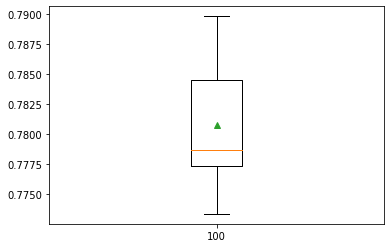

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.1.1.2- CatBoost Hyperparameter Tuning - depth

In [ ]:

# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    depth_range= np.arange(1,17)
        
#    using for loop to iterate though trees
    for i in depth_range:
        
#         building model with specified trees
        models[str(i)] = CatBoostClassifier(
            #only one of the parameters iterations, n_estimators, num_boost_round, 
            # num_trees should be initialized.
            iterations= 1000, 
            n_estimators = None, #  None
            num_boost_round = None,
            num_trees= None,
            cat_features=variables,
            learning_rate= None,
            task_type='GPU',
            depth = None, #   None
            max_depth= i, #In most cases, the optimal depth ranges from 4 to 10.
            # Values in the range from 6 to 10 are recommended.
            #only one of the parameters depth, max_depth should be initialized.

            nan_mode=None,
            verbose=0,
            boosting_type=None,

            subsample= None, # 

            l2_leaf_reg = None,  
            random_strength= None,

            random_state=None,
            reg_lambda=None,
            scale_pos_weight=None,
            feature_weights=None,
            penalties_coefficient=None,
            first_feature_use_penalties=None,
   
        )
    
#     returning the model
    return models

In [ ]:
models={}
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_cat_train, y_cat_train)
    
    
    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)
    
    
    # printing the accuracy score
    print('depth (%s)---accuracy( %.5f)' % (name, np.mean(accuracy)))

depth (1)---accuracy( 0.74357)
depth (2)---accuracy( 0.76264)
depth (3)---accuracy( 0.77574)
depth (4)---accuracy( 0.78343)
depth (5)---accuracy( 0.79233)
depth (6)---accuracy( 0.79632)
depth (7)---accuracy( 0.80047)
depth (8)---accuracy( 0.80400)
depth (9)---accuracy( 0.80125)
depth (10)---accuracy( 0.79890)


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


depth (11)---accuracy( 0.79478)
depth (12)---accuracy( 0.79199)


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.1.1.3- CatBoost Hyperparameter Tuning - learning_rate

In [ ]:

# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    learning_range= np.arange(0.05,1,0.05)
        
#    using for loop to iterate though trees
    for i in learning_range:
        
#         building model with specified trees
        models[str(i)] = CatBoostClassifier(
            #only one of the parameters iterations, n_estimators, num_boost_round, 
            # num_trees should be initialized.
            iterations= 1000, 
            n_estimators = None, #  None
            num_boost_round = None,
            num_trees= None,
            cat_features=variables,
            learning_rate= i,
            task_type='GPU',
            depth = None, #   None
            max_depth= 8, #In most cases, the optimal depth ranges from 4 to 10.
            # Values in the range from 6 to 10 are recommended.
            #only one of the parameters depth, max_depth should be initialized.

            nan_mode=None,
            verbose=0,
            boosting_type=None,

            subsample= None, # 

            l2_leaf_reg = None,  
            random_strength= None,

            random_state=None,
            reg_lambda=None,
            scale_pos_weight=None,
            feature_weights=None,
            penalties_coefficient=None,
            first_feature_use_penalties=None,
   
        )
    
#     returning the model
    return models

In [ ]:
models={}
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_cat_train, y_cat_train)
    
    
    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)
    
    
    # printing the accuracy score
    print('learning_rate (%s)---accuracy( %.5f)' % (name, np.mean(accuracy)))

learning_rate (0.05)---accuracy( 0.79787)
learning_rate (0.1)---accuracy( 0.80196)
learning_rate (0.15000000000000002)---accuracy( 0.80079)
learning_rate (0.2)---accuracy( 0.80146)
learning_rate (0.25)---accuracy( 0.79933)
learning_rate (0.3)---accuracy( 0.79914)
learning_rate (0.35000000000000003)---accuracy( 0.79386)


KeyboardInterrupt: ignored

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.1.2- CatBoost Fitting the Optimum Model


In [ ]:
classes_num = np.unique(y_train)
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes_num, y=y_train)
stratifiedkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
cat_variable = X.select_dtypes('object').columns.to_list()

In [ ]:
CatBoost_clf = CatBoostClassifier(
    
    #only one of the parameters iterations, n_estimators, num_boost_round, 
    # num_trees should be initialized.
    iterations= 1000, 
    n_estimators = None, #  None
    num_boost_round = None,
    num_trees= None,
    cat_features=cat_variable,
    learning_rate= 0.1,
    # task_type='GPU',
    depth = None, #   None
    max_depth= 8, #In most cases, the optimal depth ranges from 4 to 10.
    # Values in the range from 6 to 10 are recommended.
    #only one of the parameters depth, max_depth should be initialized.

    nan_mode=None,
    verbose=0,
    boosting_type=None,

    class_weights=class_weights,
    loss_function='MultiClass',

    subsample= None, # 

    l2_leaf_reg = None,  
    random_strength= None,

    random_state=None,
    reg_lambda=None,
    scale_pos_weight=None,
    feature_weights=None,
    penalties_coefficient=None,
    first_feature_use_penalties=None,
   
)

In [ ]:

# f1_cv_score = cross_val_score(CatBoost_clf, x_cat_train, y_cat_train, cv=stratifiedkf, scoring='f1_weighted')
y_pred_oos = cross_val_predict(CatBoost_clf, x_train, y_train, cv=stratifiedkf)
# y_pred_proba_oos = cross_val_predict(Ca tBoost_clf, x_cat_train, y_cat_train, cv=stratifiedkf, method='predict_proba')
CatBoost_clf.fit(x_train, y_train)

# roc_auc_total = metrics.roc_auc_score(y_cat_train, y_pred_proba_oos, multi_class='ovo', average='macro')
# fscore_total = metrics.f1_score(y_cat_train, y_pred_oos, average='weighted')
accuracy = metrics.accuracy_score(y_train, y_pred_oos)
print(f'Accuracy: {accuracy}')

KeyboardInterrupt: ignored

              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80     29033
         1.0       0.33      0.61      0.43      3885
         2.0       0.82      0.77      0.79     20542

    accuracy                           0.76     53460
   macro avg       0.66      0.72      0.67     53460
weighted avg       0.79      0.76      0.77     53460



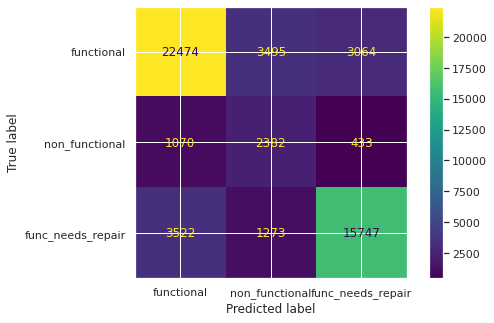

In [ ]:
print(classification_report(y_train, y_pred_oos))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_pred_oos),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
catboost_pred = CatBoost_clf.predict(x_cat_valid)

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81      3226
         1.0       0.32      0.62      0.42       432
         2.0       0.83      0.76      0.79      2282

    accuracy                           0.76      5940
   macro avg       0.66      0.72      0.67      5940
weighted avg       0.80      0.76      0.77      5940



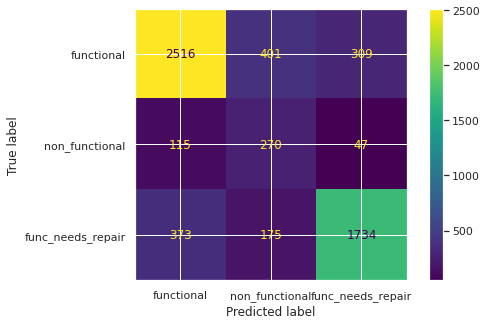

In [ ]:
print(classification_report(y_cat_valid, catboost_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, catboost_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
Cat_feature_scores = pd.Series(CatBoost_clf.feature_importances_, index=x_cat_train.columns).sort_values(ascending=False)

# feature_scores

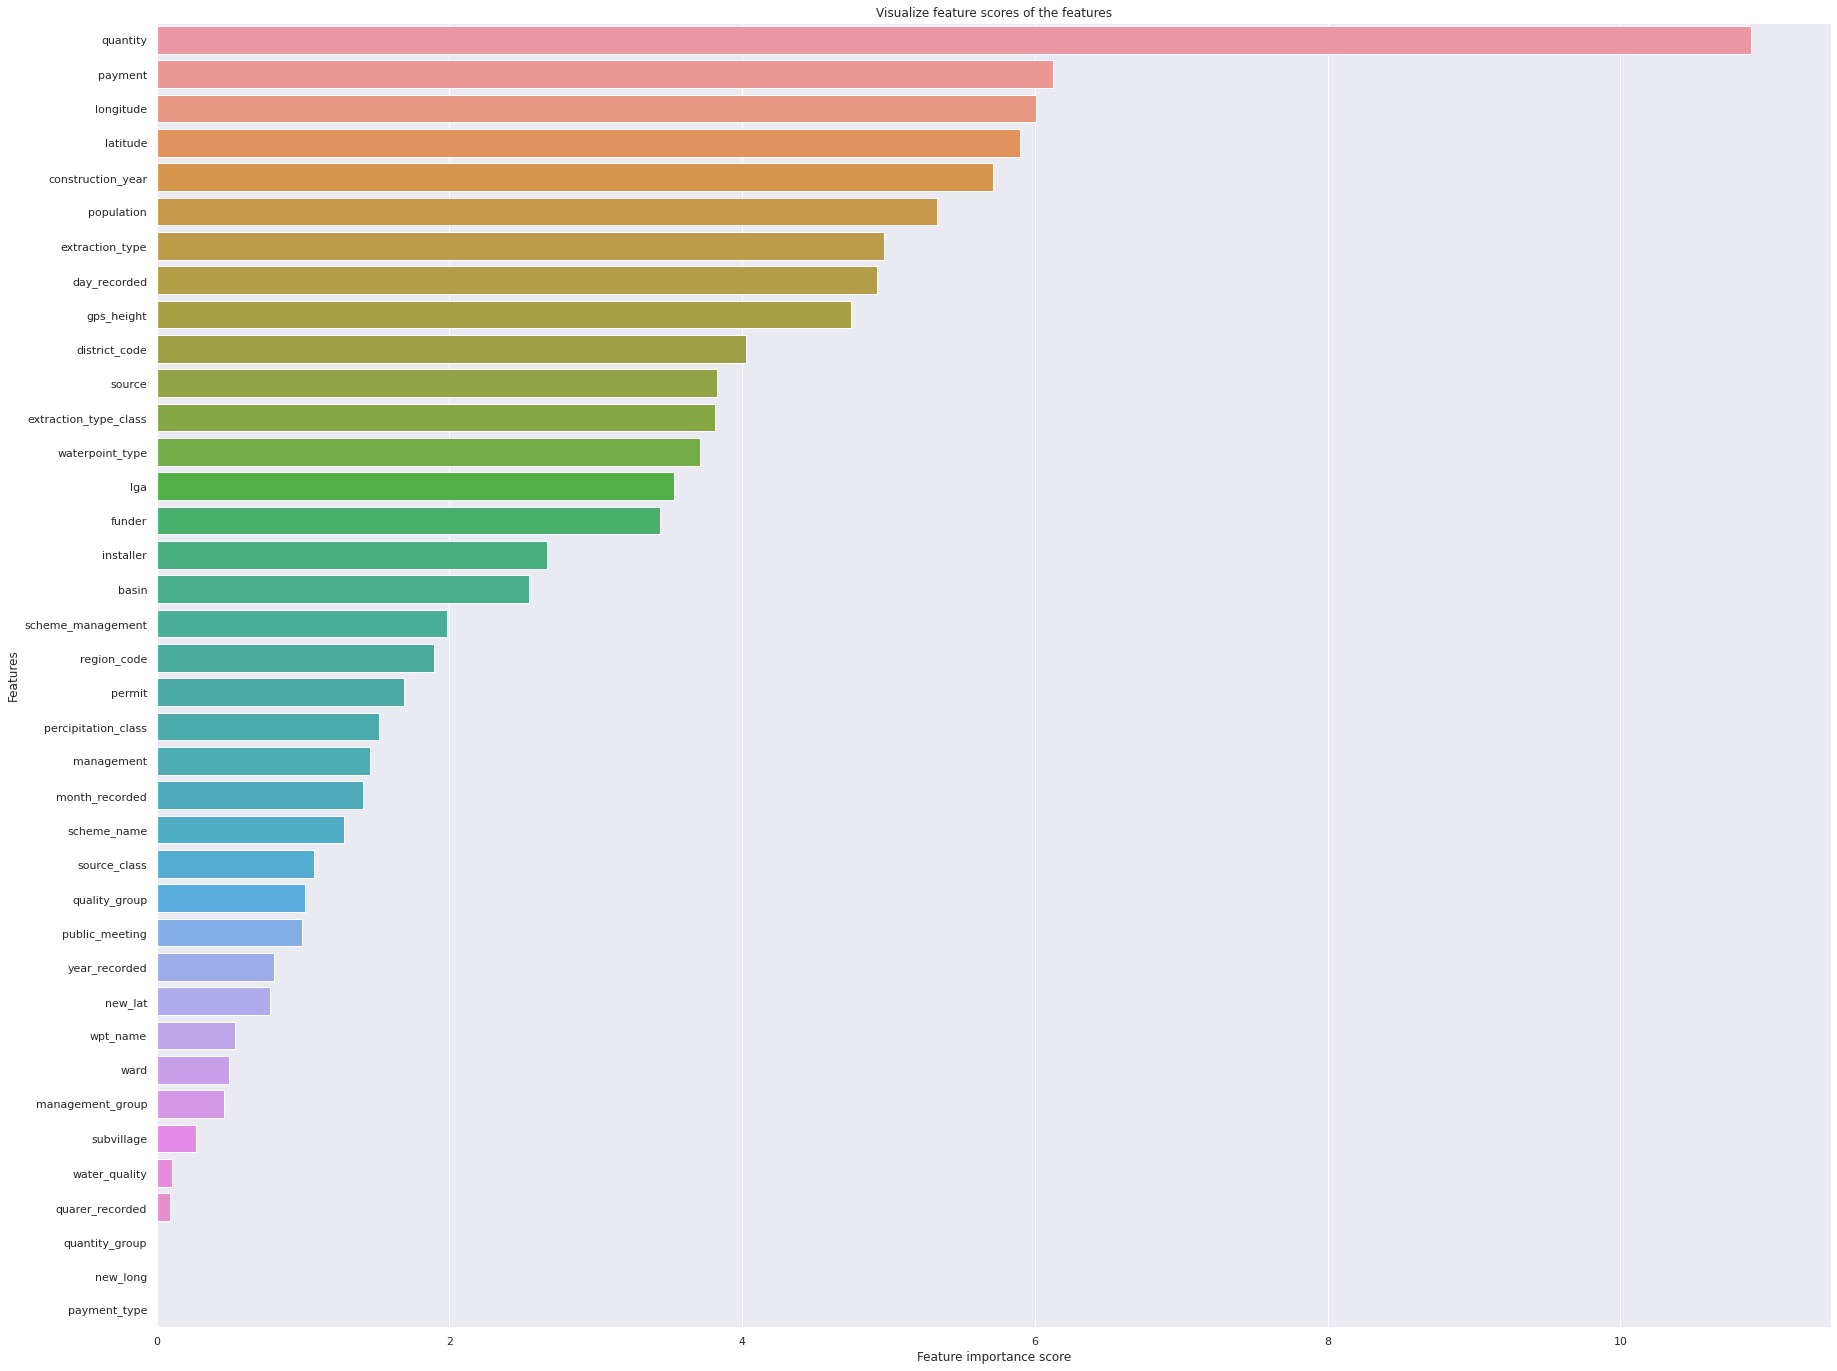

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=Cat_feature_scores, y=Cat_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(Cat_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.0- LightGBM
https://techfor-today.com/lightgbm-using-python-hyperparameter-tuning-of-lightgbm/ 

boosting_type='gbdt', num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=-1, silent=True, importance_type='split', **kwargs

In [ ]:
# importing the lightgbm module
import lightgbm as lgb
# initializing the model
LightGBM_Clf = lgb.LGBMClassifier(
    boosting_type='gbdt',
    num_leaves = 50,
    max_depth=-1,
    learning_rate = 0.2,
    n_estimators=1000,
    subsample_for_bin=200000,
    objective=None,
    class_weight= None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=17, 
    n_jobs=-1, 
    silent=True, 
    importance_type='split',
    verbosity = 1,
    
)



In [ ]:
x_train.shape

(53460, 68)

In [ ]:
y_pred_oos = cross_val_predict(LightGBM_Clf, x_train, y_train, cv=stratifiedkf)
LightGBM_Clf.fit(x_train, y_train)
accuracy = metrics.accuracy_score(y_train, y_pred_oos)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8015712682379349


              precision    recall  f1-score   support

           0       0.81      0.87      0.84     29033
           1       0.51      0.35      0.42      3885
           2       0.83      0.78      0.81     20542

    accuracy                           0.80     53460
   macro avg       0.72      0.67      0.69     53460
weighted avg       0.80      0.80      0.80     53460



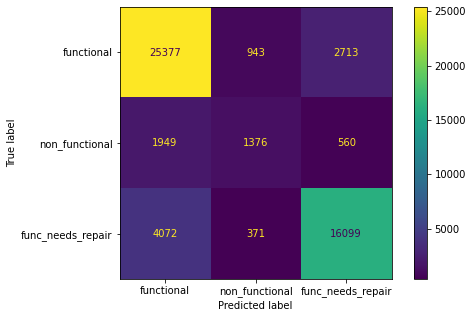

In [ ]:
print(classification_report(y_train, y_pred_oos))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_pred_oos),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
# making prediction 
LightGBM_pred = LightGBM_Clf.predict(x_valid)

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      3226
           1       0.52      0.36      0.43       432
           2       0.83      0.79      0.81      2282

    accuracy                           0.81      5940
   macro avg       0.72      0.68      0.69      5940
weighted avg       0.80      0.81      0.80      5940



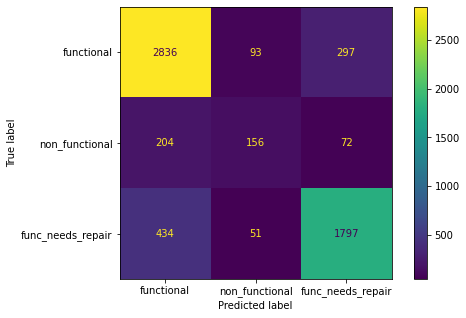

In [ ]:
print(classification_report(y_valid, LightGBM_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, LightGBM_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
LightGBM_feature_scores = pd.Series(LightGBM_Clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# feature_scores

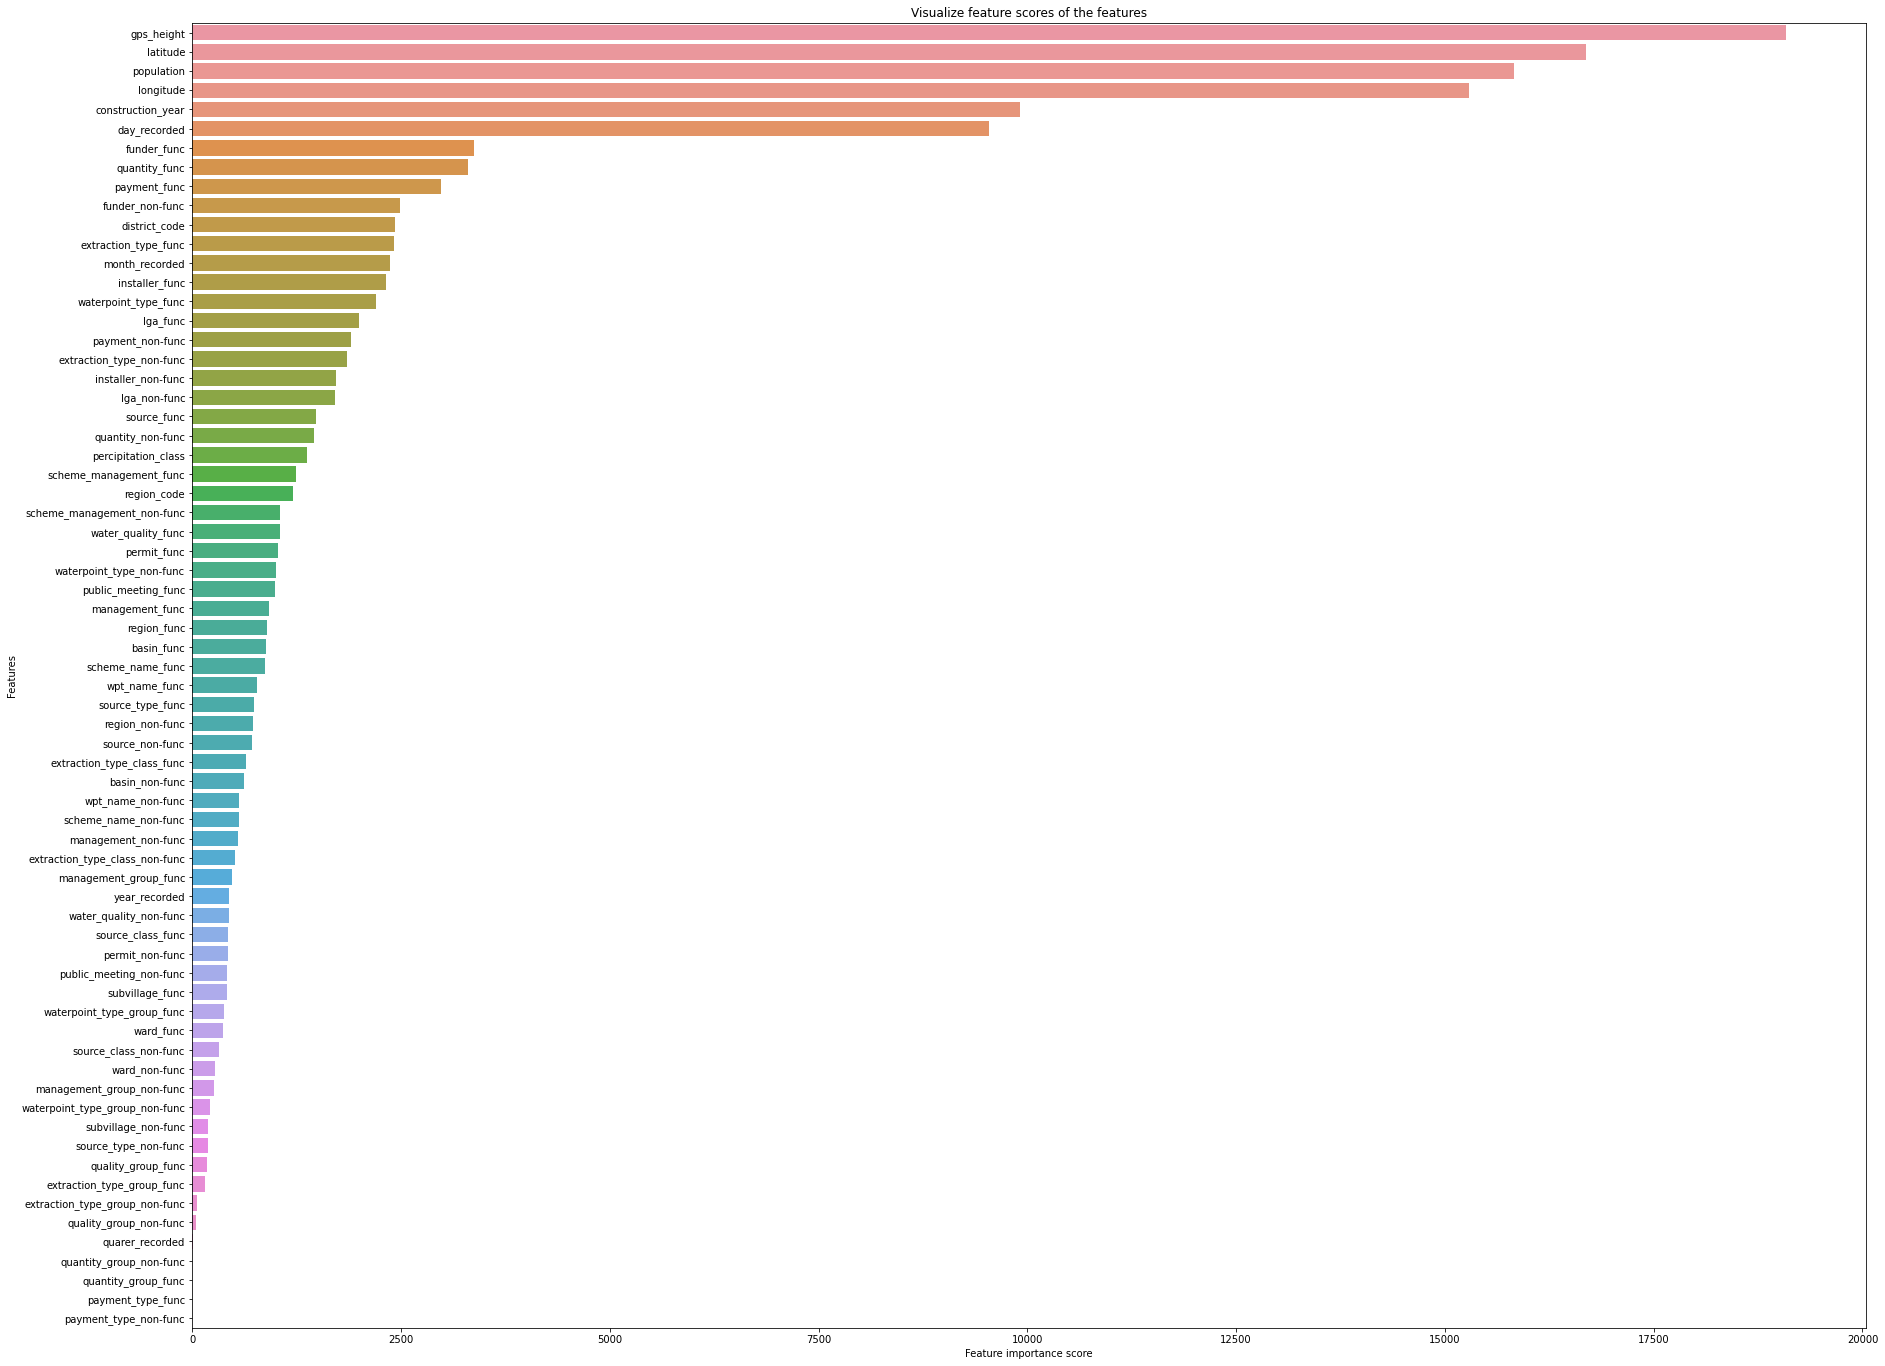

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=LightGBM_feature_scores, y=LightGBM_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(LightGBM_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
# test.drop(['status_group', 'id'], axis=1, inplace=True)

In [ ]:
lightGB_preds_test = LightGBM_Clf.predict(test)
test_lightGBoutput=test
test_lightGBoutput['status_group'] = lightGB_preds_test
test_lightGBoutput['id']=test_id
test_lightGBoutput['status_group'] = test_lightGBoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})
drive.mount('drive', force_remount=True)
test_lightGBoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/LightGBoutput.csv', encoding='utf-8', index=False, header=True)

Mounted at drive


###4.0.1- Hyperparameter tuning of LightGBM

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
    
    
    # validating the model based on the accurasy score
    r_square = cross_val_score(model, Input, Ouput, scoring='r2', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return r_square

Finding the optimum number of iterations in LightGBM

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500, 1000]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = lgb.LGBMRegressor(n_estimators=i)
    
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    R_square = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(R_square)
    names.append(name)
    
    
    # printing the accuracy score
    print('Iterations (%s)---R-square( %.5f)' % (name, np.mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

Finding the optimum number of Features in LightGBM

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    models = dict()
    
    # explore features numbers from 1-5
    for i in range(1,6):
        
#         appending the models
        models[str(i)] = lgb.LGBMRegressor(max_features=i)
    
#     returining the models
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, Input, Output)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('---->Features(%s)---R_square( %.5f)' % (name, mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

Finding the optimum sample size in LightGBM

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = lgb.LGBMRegressor(subsample=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, Input, Output)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Samples(%s)---R_square( %.5f)' % (name, mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

Finding the optimum learning rate in LightGBM

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.0001, 0.001, 0.01, 0.1, 1.0]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = lgb.LGBMRegressor(learning_rate=i)
    return models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    R_square = evaluate_model(model, Input, Output)
    
#     storing the accurcy
    results.append(R_square)
    names.append(name)
    
#     printing
    print('Learning Rate(%s)---R Square( %.5f)' % (name, mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

Finding the optimum depth of tree in LightGBM

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,12):
        
#         appending the models
        models[str(i)] = lgb.LGBMRegressor(max_depth=i)
        
#   returining the model
    return models

In [ ]:
# calling the function
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    R_square = evaluate_model(model, Input, Output)
    
    # appending the results
    results.append(R_square)
    names.append(name)
    
#     printing the results
    print('Decision tree depth (%s)---R_square( %.5f)' % (name, mean(R_square)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

##4.2- Random Forest 

### 4.2.1- Hyper Parameter Tuning for Random Forest - sequential Approach

####4.2.1.1- Finding the optimum number of iterations, number of stumps
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [50, 75, 100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            criterion = 'gini', #{“gini”, “entropy”, “log_loss”}, default=”gini”
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features='sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.2.1.2- Finding the optimum criterion

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    criterions= ['gini', 'entropy']
        
#    using for loop to iterate though trees
    for i in criterions:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = 300,
                            criterion = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features='sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.2.1.3- Finding the max_features

In [ ]:
x_train.info()

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    Num_features= [1, 2, 3, 4, 5, 6, 'sqrt', 'log2', 7, 8, 9, 10, None]
        
#    using for loop to iterate though trees
    for i in Num_features:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = RandomForestClassifier(
                            n_estimators = 300,
                            criterion = 'entropy', 
                            max_depth = None, # the larger the more prone to overfit, range 3-10
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= i, #{“sqrt”, “log2”, None}, int or float, default=”sqrt”#>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.2.3- RandomizedSearchCV Hyperparameter Tuning for Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In [ ]:
# defiing the model
rf_model = RandomForestClassifier(
                            # n_estimators = 300,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=2,
                            min_samples_leaf=1, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”#>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 2,
                            n_jobs = -1,
                            random_state = 17,
)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(50,900)



In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = rf_model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                #  , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of Random Forest
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.3.3- Fitting the Optimum Random Forest Model

In [ ]:
rf_clf = RandomForestClassifier(
                            n_estimators = 1000,
                            criterion = 'entropy', 
                            max_depth = None, # 
                            min_samples_split=5,
                            min_samples_leaf=4, 
                            max_features= 'sqrt', #{“sqrt”, “log2”, None}, int or float, default=”sqrt”
                            max_leaf_nodes = None, #Grow trees with max_leaf_nodes in best-first fashion. 
                            #Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
                            min_impurity_decrease = 0, #A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
                            bootstrap = True,
                            warm_start = False, #When set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest
                            class_weight = 'balanced',
                            max_samples = None,
                            verbose = 1,
                            n_jobs = -1,
                            random_state = 17,
)

In [ ]:
y_pred_oos = cross_val_predict(rf_clf, x_train, y_train, cv=stratifiedkf)
rf_clf.fit(x_train, y_train)
accuracy = metrics.accuracy_score(y_train, y_pred_oos)
print(f'Accuracy: {accuracy}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   29.4s
[Parall

Accuracy: 0.7798166853722409


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


              precision    recall  f1-score   support

           0       0.83      0.81      0.82     29033
           1       0.37      0.61      0.46      3885
           2       0.84      0.77      0.80     20542

    accuracy                           0.78     53460
   macro avg       0.68      0.73      0.69     53460
weighted avg       0.80      0.78      0.79     53460



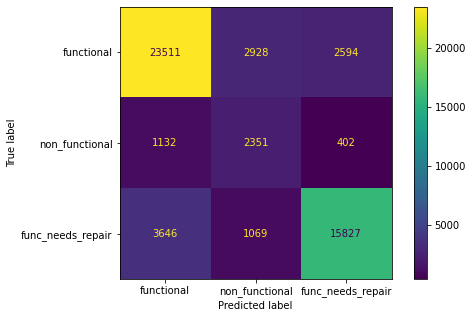

In [ ]:
print(classification_report(y_train, y_pred_oos))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_pred_oos),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

####Perform Prediction and Display Results for Random Forest

In [ ]:
rf_preds = rf_clf.predict(x_valid)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    1.4s finished


              precision    recall  f1-score   support

           0       0.84      0.81      0.83      3226
           1       0.35      0.59      0.44       432
           2       0.85      0.77      0.81      2282

    accuracy                           0.78      5940
   macro avg       0.68      0.73      0.69      5940
weighted avg       0.81      0.78      0.79      5940



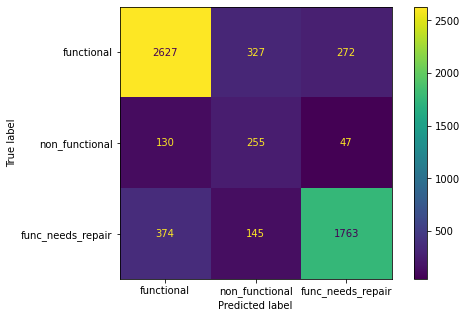

In [ ]:
print(classification_report(y_valid, rf_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, rf_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

####Feature Importance - Random Forest

In [ ]:
test.drop('amount_tsh', axis=1, inplace=True)

In [ ]:
rf_feature_scores = pd.Series(rf_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# feature_scores

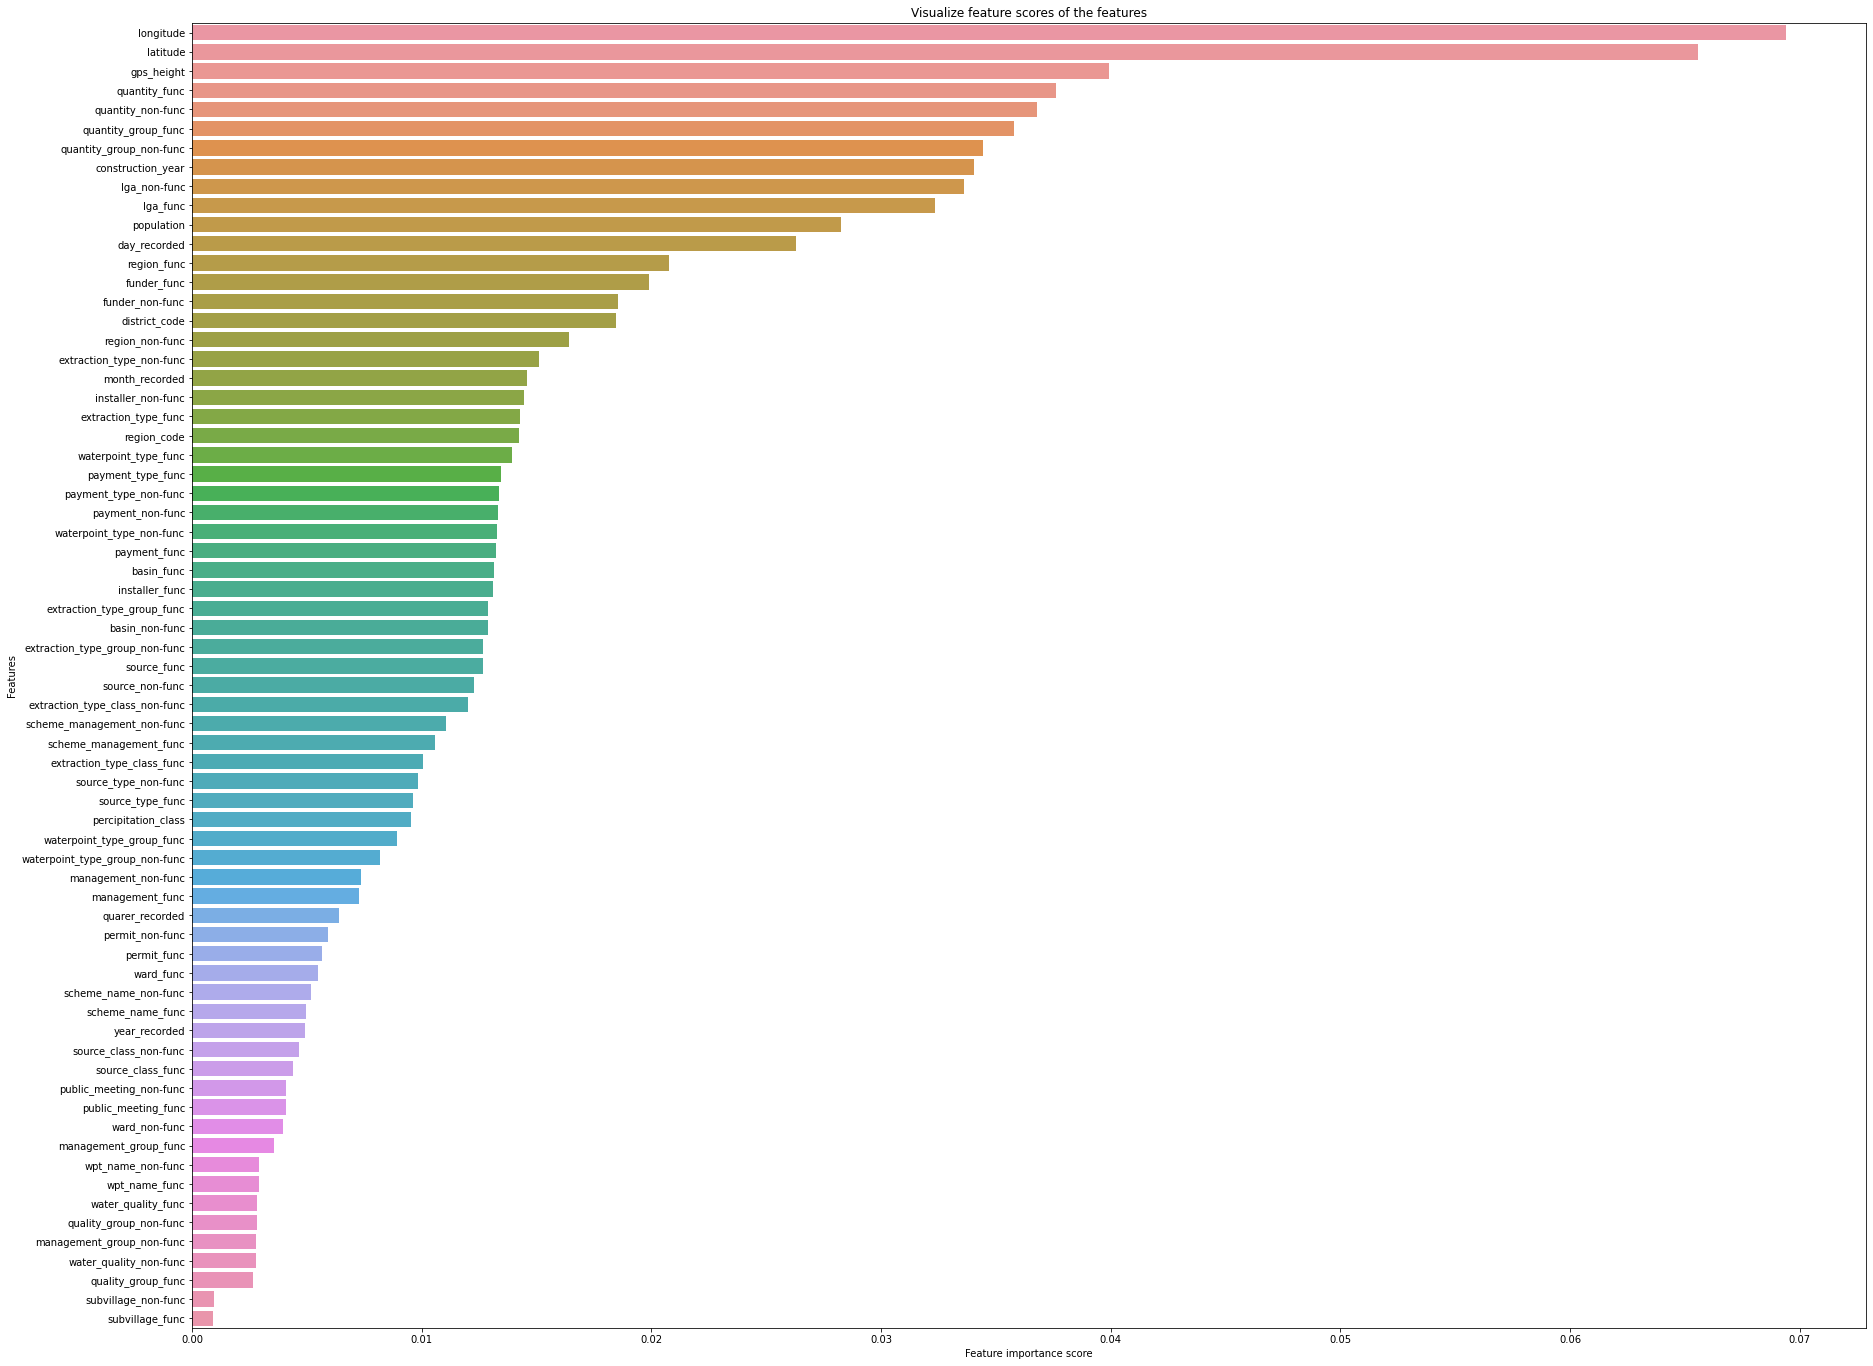

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=rf_feature_scores, y=rf_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(rf_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
rf_preds_test = rf_clf.predict(test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    2.9s finished


In [ ]:
test_RFoutput=test
test_RFoutput['status_group'] = rf_preds_test

In [ ]:
test_RFoutput['id']=test_id

In [ ]:
#0 functional
#1 functional needs repair
#non functional
test_RFoutput['status_group'] = test_RFoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
test_RFoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/RFoutput.csv', encoding='utf-8', index=False, header=True)

Mounted at drive


##4.4- eXtreme Gradient boosting
Main features:
* 1- Cross-validation at each iteration: Cross-validation is a process in which the model is tested using different portions of the dataset in each iteration. The XGBoost algorithm has an internal parameter for the cross-validation and it tests each of the weak learners using the cross-validation method.
* 2- Parallel process: XGBoost uses OpenMP for parallel processing. But unlike random forests which create trees in parallel, the XGBoost creates individual trees using a parallel process.
* 3- Regularization: In Machines, learning regularization is a technique that is commonly used to reduce the risk of overfitting. Overfitting is when the models learn too many specific patterns about the training dataset and fail to generalize on the testing dataset. So, the XGBoost uses different regularization techniques in order to make sure that the model is not overfitted and that the findings can be generalized to the testing dataset.
* 4- Missing values: One of the essential features of the XGBoost algorithm is that it can handle the missing values automatically. That means we don’t need to handle missing values in the preprocessing step.
* 5- Tree pruning: Tree pruning is the process of removing the nodes from the trees that do not contribute to the classification.

https://techfor-today.com/hyperparameter-tuning-of-xgboost-algorithm/#Finding_the_optimum_number_of_features_using_Hyperparameter_tuning_of_XGBoost

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

###4.3.1- Hyper Parameter Tuning for eXtreme Gradient Boosting - sequential Approach
1- Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2- Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3- Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4- Lower the learning rate and decide the optimal parameters.

https://kevinvecmanis.io/machine%20learning/hyperparameter%20tuning/dataviz/python/2019/05/11/XGBoost-Tuning-Visual-Guide.html

https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook

####4.3.1.1- Finding the optimum number of iterations, number of stumps

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    models = dict()
    
    # number of decision stumps
    decision_stump= [100, 150, 200, 300, 400, 500, 600, 700]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        # models[str(i)] = XGBClassifier(n_estimators=i)

        models[str(i)] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = i,#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.3,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
) 
#     returning the model
    return models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=17)
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)  
    # returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    accuracy = evaluate_model(model, x_train, y_train)

    # appending the accuray socres in results
    results.append(accuracy)
    names.append(name)

    # printing -Hyperparameter tuning of XGBoost
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding the optimum sample size

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models = {}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():

    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding optimum learning rate 

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    models = dict()
    
#     different learning rates
    for i in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        models[k] = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = i, # range [0,1], typically=0.01-0.2 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
    return models

In [ ]:
# calling the function
models ={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.5- Finding the optimum depth 

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,13):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = i, # the larger the more prone to overfit, range 3-10 >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.6- Finding the optimum colsample_bytree

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 0, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = i, #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            colsample_bylevel = i,
                            colsample_bynode = i,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('Portion of Features Selected - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

####4.3.1.7- Finding the optimum scale_pos_weight

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in np.arange(0.1, 1.1, 0.1):
        
#         appending the models
        models[str(i)] = XGBClassifier(max_depth = 7, # the larger the more prone to overfit, range 3-10 
                            learning_rate = 0.1, # range [0,1], typically=0.01-0.2 
                            n_estimators = 600,
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.6, 
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = i, #[default=1] #>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Iterating Through
                            random_state = 17,
        )
        
#   returining the model
    return models

In [ ]:
# calling the function
models = {}
models = build_models()

# creating lists 
results, names = list(), list()

# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Hyperparameter tuning of XGBoost
    print('scale_pos_weight - colsample_by (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)

# showing the plot
plt.show()

###4.3.2- RandomizedSearchCV for Hyperparameter tuning of XGBoost

In [ ]:
# defiing the model
model = XGBClassifier( 
                            verbosity = 2,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = 1,
                            colsample_bytree = 0.5, 
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            scale_pos_weight = 0.6, #[default=1] 
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(400,900)

# values for learning rate
grid['learning_rate'] = [0.08, 0.09, 0.1]

# values for the sample
grid['subsample'] = np.arange(0.3, 0.81, 0.025)

# values for teh depth of tree
grid['max_depth'] = [4, 5, 6, 7, 8, 9, 10]

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                #  , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.3.3 Fitting the Optimum Model

In [ ]:
xgboost_clf = XGBClassifier(max_depth = 8, # the larger the more prone to overfit, range 3-10
                            learning_rate = 0.09, # range [0,1], typically=0.01-0.2
                            n_estimators = 1000,
                            verbosity = 1,
                            objective = "multi:softmax",
                            booster = "gbtree", # gblinear or dart
                            n_jobs = -1,
                            gamma = 0, 
                            # Minimum loss reduction required to split. range=[0,inf],
                            # The larger gamma is, the more conservative the algorithm will be.
                            min_child_weight = 1, # used to restrict overfitting
                            max_delta_step = 0,
                            subsample = 0.75,
                            colsample_bytree = 0.5,
                            colsample_bylevel = 0.5,
                            colsample_bynode = 0.5,
                            reg_alpha = 0,
                            reg_lambda = 1,
                            scale_pos_weight = 0.5, #[default=1]
                            random_state = 17,
                            
)

In [ ]:
x_train

,gps_height,longitude,latitude,region_code,region_code,district_code,district_code,population,construction_year,new_lat,new_long,imputed_population,original_population,year_recorded,month_recorded,day_recorded,quarer_recorded,percipitation_class,extraction_type_func,extraction_type_non-func,funder_func,funder_non-func,region_code_func,region_code_non-func,district_code_func,district_code_non-func,lga_func,lga_non-func,installer_func,installer_non-func,wpt_name_func,wpt_name_non-func,subvillage_func,subvillage_non-func,ward_func,ward_non-func,scheme_name_func,scheme_name_non-func,basin_func,basin_non-func,region_func,region_non-func,public_meeting_func,public_meeting_non-func,permit_func,permit_non-func,extraction_type_group_func,extraction_type_group_non-func,extraction_type_class_func,extraction_type_class_non-func,management_func,management_non-func,management_group_func,management_group_non-func,payment_func,payment_non-func,payment_type_func,payment_type_non-func,water_quality_func,water_quality_non-func,quality_group_func,quality_group_non-func,quantity_func,quantity_non-func,quantity_group_func,quantity_group_non-func,source_func,source_non-func,source_type_func,source_type_non-func,source_class_func,source_class_non-func,waterpoint_type_func,waterpoint_type_non-func,waterpoint_type_group_func,waterpoint_type_group_non-func,scheme_management_func,scheme_management_non-func
15535,252.0,39.008625,-10.895845,90,90.0,33,33.0,50.000000,1996.0,40.0,0.0,0.0,50.0,2013.0,2.0,5.0,1.0,2.0,0.599253,0.299888,0.294118,0.502262,90.0,90.0,33.0,33.0,0.195076,0.676136,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.371689,0.555753,0.302890,0.624277,0.556899,0.370195,0.517094,0.407443,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.38735,0.660482,0.227831,0.660482,0.227831,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.622290,0.302744,0.622290,0.302744,0.542320,0.397825,0.621485,0.299278,0.576491,0.339523,0.515315,0.421249
7478,1598.0,37.895652,-4.132007,3,3.0,3,3.0,150.000000,2010.0,38.0,0.0,0.0,150.0,2013.0,3.0,4.0,1.0,4.0,0.599253,0.299888,0.596308,0.298555,3.0,3.0,3.0,3.0,0.511973,0.338655,0.625179,0.247496,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.600895,0.345749,0.602877,0.323590,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.504234,0.426864,0.538236,0.38735,0.752334,0.179846,0.752334,0.179846,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.568560,0.304411,0.542257,0.338923,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.513162,0.344751
23898,2031.0,31.719997,-7.932255,15,15.0,4,4.0,4530.000000,2009.0,32.0,0.0,0.0,4530.0,2013.0,2.0,2.0,1.0,2.0,0.603333,0.363750,0.603922,0.337531,15.0,15.0,4.0,4.0,0.473133,0.475659,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.514379,0.414471,0.407498,0.482478,0.391040,0.534292,0.429871,0.482690,0.554437,0.376145,0.603333,0.363750,0.630469,0.309067,0.504234,0.426864,0.538236,0.38735,0.448911,0.475856,0.448911,0.475856,0.565941,0.357236,0.565941,0.357236,0.025136,0.968940,0.025136,0.968940,0.494769,0.448348,0.494769,0.448348,0.542320,0.397825,0.617852,0.323307,0.617852,0.323307,0.515315,0.421249
31464,1289.0,30.210195,-4.508513,16,16.0,2,2.0,540.000000,2001.0,30.0,0.0,0.0,540.0,2013.0,2.0,1.0,1.0,2.0,0.599253,0.299888,0.603922,0.337531,16.0,16.0,2.0,2.0,0.583572,0.224451,0.574318,0.370744,0.532528,0.392061,0.544987,0.382558,0.526244,0.399379,0.571487,0.355492,0.483053,0.401586,0.484020,0.301847,0.556899,0.370195,0.554437,0.376145,0.599253,0.299888,0.599253,0.299888,0.739857,0.169792,0.538236,0.38735,0.660482,0.227831,0.660482,0.227831,0.565941,0.357236,0.565941,0.357236,0.652323,0.275357,0.652323,0.275357,0.568560,0.304411,0.542257,0.338923,0.545168,0.336960,0.621485,0.299278,0.576491,0.339523,0.513162,0.344751
29837,1252.0,37.184309,-3.248099,3,3.0,5,5.0,140.000000,1999.0,37.0,0.0,0.0,140.0,2013.

In [ ]:
y_pred_oos = cross_val_predict(xgboost_clf, x_train, y_train, cv=stratifiedkf)
xgboost_clf.fit(x_train, y_train)
accuracy = metrics.accuracy_score(y_train, y_pred_oos)
print(f'Accuracy: {accuracy}')

              precision    recall  f1-score   support

         0.0       0.80      0.90      0.85     29033
         1.0       0.59      0.34      0.43      3885
         2.0       0.85      0.77      0.81     20542

    accuracy                           0.81     53460
   macro avg       0.75      0.67      0.70     53460
weighted avg       0.80      0.81      0.80     53460



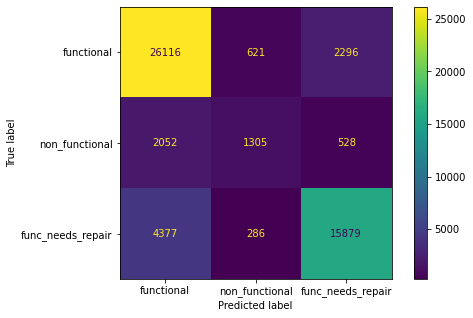

In [ ]:
print(classification_report(y_train, y_pred_oos))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_pred_oos),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
xgboost_preds = xgboost_clf.predict(x_valid)

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85      3226
         1.0       0.59      0.35      0.44       432
         2.0       0.86      0.77      0.81      2282

    accuracy                           0.81      5940
   macro avg       0.75      0.68      0.70      5940
weighted avg       0.81      0.81      0.81      5940



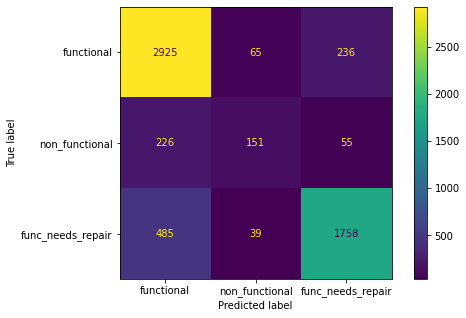

In [ ]:
print(classification_report(y_valid, xgboost_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, xgboost_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
xgboost_feature_scores = pd.Series(xgboost_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# xgboost_feature_scores

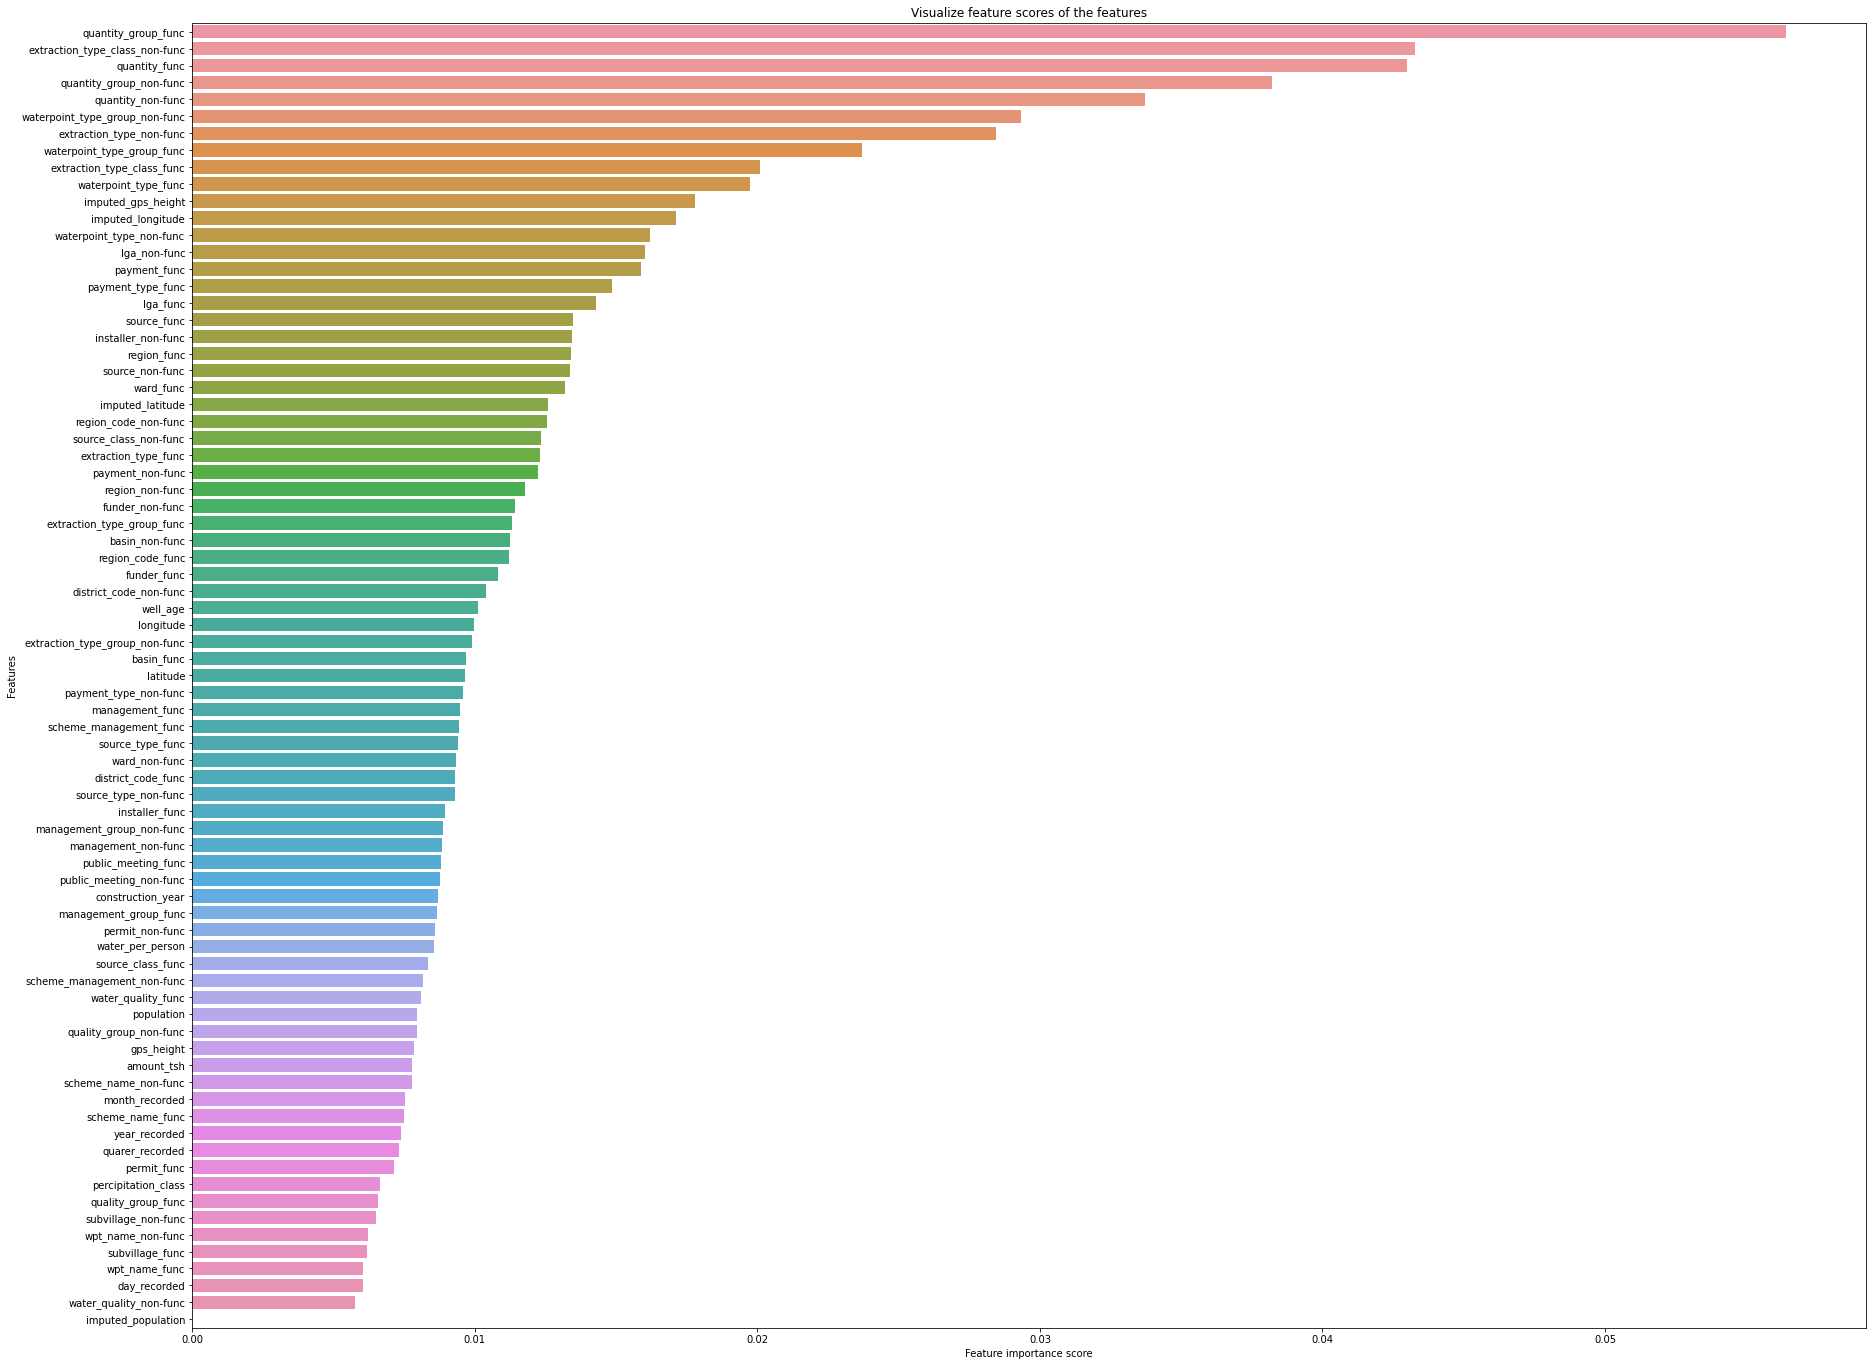

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=xgboost_feature_scores, y=xgboost_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(xgboost_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [ ]:
test=test.drop(['status_group', 'id'], axis=1)

In [ ]:
xgboost_preds_test = xgboost_clf.predict(test)

In [ ]:
test_XGBoutput=test
test_XGBoutput['status_group'] = xgboost_preds_test

In [ ]:
test_XGBoutput['id']=test_id

In [ ]:
test_XGBoutput['status_group'] = test_XGBoutput['status_group'].map({ 0:'functional', 1:'functional needs repair', 2:'non functional'})

In [ ]:
from google.colab import drive
drive.mount('drive', force_remount=True)
test_XGBoutput[[ 'id','status_group']].to_csv('/content/drive/My Drive/Colab Notebooks/XGBoutput.csv', encoding='utf-8', index=False, header=True)

Mounted at drive


##4.3- Gradient Boosting
Gradient Tree Boosting, Stochastic Gradient Boosting, and GBM are other names for the Gradient Boosting Algorithm. It creates a sequence of weak models ( usually decision trees) and comes up with a final strong learner. Each prediction in gradient boosting aims to outperform the one before it by lowering the errors. Gradient Boosting’s key principle is that it fits a new predictor to the residual errors created by the preceding predictor rather than fitting a prediction to the data at each iteration.

https://techfor-today.com/gradient-boosting-algorithm-using-python/



###4.3.1- Hyper Parameter Tuning for Gradient Boosting

GradientBoostingClassifier(*, loss: str = "deviance", learning_rate: float = 0.1, n_estimators: int = 100, subsample: float = 1, criterion: str = "friedman_mse", min_samples_split: int = 2, min_samples_leaf: int = 1, min_weight_fraction_leaf: float = 0, max_depth: int = 3, min_impurity_decrease: float = 0, init: Any | None = None, random_state: Any | None = None, max_features: Any | None = None, verbose: int = 0, max_leaf_nodes: Any | None = None, warm_start: bool = False, validation_fraction: float = 0.1, n_iter_no_change: Any | None = None, tol: float = 0.0001, ccp_alpha: float = 0)

####4.3.1.1- Finding the optimum number of trees in Gradient boosting

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    GB_models = dict()
    
    # number of decision stumps
    decision_stump= [150, 200, 250, 300]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        GB_models[str(i)] = GradientBoostingClassifier(n_estimators=i)
    
#     returning the model
    return GB_models

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1)
    
#     returning the accuracy score
    return accuracy

In [ ]:
# calling the build_models function
models = {}
models = build_models()
# creating list
results, names = list(), list()
# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing - Gradient boosting algorithm using Python
    print('---->Iterations (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.2- Finding the optimum depth of trees in the Gradient boosting algorithm using Python

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     specifying the depth of trees
    for i in range(1,7):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_depth=i)
        
#   returining the model
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing - Gradient boosting algorithm using Python
    print('---->Decision tree depth (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.3- Finding an optimum Learning rate in Gradient boosting algorithm using Python

In [ ]:
# creating function
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
#     different learning rates
    for i in [0.05, 0.1, 0.2, 0.5, 1.0, 1.5]:
        
#         key value
        k = '%.4f' % i
    
#     appending the models
        GB_models[k] = GradientBoostingClassifier(learning_rate=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing learning rate of Gradient boosting algorithm using Python
    print('---->Learning Rate(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding an optimum number of features in the Gradient boosting algorithm using Python
Each decision tree can have a different amount of attributes that are utilized to suit it. Similar to modifying the sample size, changing the number of features gives more variance to the model, which may enhance performance.

In [ ]:
# creating the function 
def build_models():
    
#     creating dic of models
    GB_models = dict()
    
    # explore features numbers from 1-4
    for i in range(1,5):
        
#         appending the models
        GB_models[str(i)] = GradientBoostingClassifier(max_features=i)
    
#     returining the models
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing features of Gradient boosting algorithm using Python
    print('---->Features(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.3.1.4- Finding the optimum number of samples in the Gradient boosting algorithm using Python
You can change how many samples were used to fit each tree. This indicates that a randomly chosen portion of the training dataset is used to fit each tree. Using fewer samples introduces more variance for each tree, although it can improve the overall performance of the model. Let us now create a function that returns multiple models with different sample values.

In [ ]:
# creating the function
def build_models():
    
#     dic of models
    GB_models = dict()
    
#     exploring different sample values
    for i in np.arange(0.1, 1.1, 0.1):
        
#         key value
        k = '%.1f' % i
    
#     appending the model
        GB_models[k] = GradientBoostingClassifier(subsample=i)
    return GB_models

In [ ]:
# calling the function
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing sampes for Gradient boosting algorithm using Python
    print('---->Samples(%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

###4.3.2- GridSearchCV for Gradient boosting algorithm using Python

In [ ]:
# defiing the model
model = GradientBoostingClassifier()
# creating a dict of grids
grid = dict()
# values for iteration
grid['n_estimators'] = [10, 50, 100, 500]
# values for learning rate
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# values for the sampel
grid['subsample'] = [0.5, 0.7, 1.0]
# values for teh depth of tree
grid['max_depth'] = [3, 4, 5]

In [ ]:
# defining the cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
# applying the gridsearchcv method
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# storing the values
grid_result = grid_search.fit(x_train, y_train)
# printing the best parameters of Gradient boosting algorithm using Python
print("Accuracy score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

###4.3.3- Fitting the Optimum Mode

##4.4- ADABoostClassifier
The training algorithm involves starting with one decision tree, finding those examples in the training dataset that were misclassified, and adding more weight to those examples. Another tree is trained on the same data, although now weighted by the misclassification errors. This process is repeated until a desired number of trees are added.

https://machinelearningmastery.com/adaboost-ensemble-in-python/

https://www.datacamp.com/tutorial/adaboost-classifier-python#adaboost-classifier

https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

https://vitalflux.com/differences-between-random-forest-vs-adaboost/

https://vitalflux.com/adaboost-algorithm-explained-with-python-example/#:~:text=Base%20estimators%20for%20Adaboost%20algorithm,in%20classifier%20with%20high%20variance.

https://techfor-today.com/hyperparameter-tuning-of-adaboost/

###4.4.1- Hyper Parameter Tuning for AdaBoosting - Sequential Approach

####4.4.1.1- The optimum number of trees in Adaboost
Create a function that will build various Ada boost models. And for the model, we will specify a different number of decision stumps starting from 50 to 1000.

In [ ]:
# fuction to create models
def build_models():
    
#     dic of models
    Ada_models = dict()
    
    # number of decision stumps
    decision_stump= [10, 50, 100, 500]
        
#    using for loop to iterate though trees
    for i in decision_stump:
        
#         building model with specified trees
        models[str(i)] = AdaBoostClassifier(n_estimators=i, random_state=7)
    return models

The next step is to build a function for the validation of the models. In this case, we will use the cross-validation method. Let us build the function which returns the accuracy score of the models.

In [ ]:
# function for the validation of model
def evaluate_model(model, Input, Ouput):
    
    # defining the method of validation
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    
    
    # validating the model based on the accurasy score
    accuracy = cross_val_score(model, Input, Ouput, scoring='accuracy', cv=cv, n_jobs=-1, random_state=7)
    
#      accuracy score- hyperparameter tuning of Adaboost
    return accuracy

Now, we will call the above functions which will create the models and will evaluate them based on the accuracy score.

In [ ]:
# calling the build_models function
models = {}
models = build_models()

# creating list
results, names = list(), list()

# using for loop to iterate thoug the models
for name, model in models.items():
    
    # calling the validation function
    scores = evaluate_model(model, x_train, y_train)
    
    
    # appending the accuray socres in results
    results.append(scores)
    names.append(name)
    
    
    # printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(scores)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.2- Tunning the weak learner in Ada boost - max_depth
A decision tree with one level is used as a weak learner by default in the Ada boost. We can increase the depth of the stump tree to get the optimum depth tree.

In [ ]:
# building function for the model
def build_models():
    
#     creating dic of models
    models = dict()
    
#     specifying the depth of trees
    for i in range(1,8):
        
        # model
        base_model = DecisionTreeClassifier(max_depth=i, random_state=7)
        
        # creating dic of modles
        models[str(i)] = AdaBoostClassifier(base_estimator=base_model, random_state=7)
        
#   returining the model -results of hyperparameter tuning of Adaboost
    return models

In this section, we will not again build the evaluation function, as we have already created in the above section. So, we can use it here as well.

In [ ]:
# calling the function
models={}
models = build_models()
# creating lists 
results, names = list(), list()
# iterating through the models
for name, model in models.items():
    
    # calling the evalution function
    accuracy = evaluate_model(model, x_train, y_train)
    
    # appending the results
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# plotting box plot of the 
plt.boxplot(results, labels=names,showmeans=True)
# showing the plot
plt.show()

####4.4.1.3- Tuning learning rate in Ada boost
Learning rate is simply the step size of each iteration. The default value of the learning rate in the Ada boost is 1. We will now use the hyperparameter tuning method to find the optimum learning rate for our model.

In [ ]:
# building the models
def build_models():
    
#     creating the model dic
    models = dict()
    
    
    # learning rate for various values
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.3f' % i
        
#         models in dic
        models[key] = AdaBoostClassifier(learning_rate=i, random_state=7)
    
#     returning models -results of hyperparameter tuning of Adaboost
    return models

In [ ]:
# calling the function
models={}
models = build_models()
# creating the list
results, names = list(), list()
# for loop to iterate through the models
for name, model in models.items():
    
    
    # calling the evaluting function
    accuracy = evaluate_model(model, x_train, y_train)
    
#     storing the accurcy
    results.append(accuracy)
    names.append(name)
    
#     printing results of hyperparameter tuning of Adaboost
    print('---->Stump tree (%s)---Accuracy( %.5f)' % (name, np.mean(accuracy)))

In [ ]:
# fixing the size
plt.figure(figsize=(10, 8))
# plotting the values
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

###4.4.2- RandomizedSearchCV for Hyperparameter tuning of AdaBoosting
In the second aproach, we will use the RandomizedSearchCV method to find the optimum values for the parameters of the Ada boost algorithm using the same dataset. 

In [ ]:
# defiing the model
dtree = DecisionTreeClassifier(random_state=17)

grid_dtree= dict()

# values for iteration
grid_dtree['criterion'] = ['gini', 'entropy']

# values for iteration
grid_dtree['max_depth'] = np.arange(1,11)

In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = dtree
                                 , param_distributions=grid_dtree
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = None # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

In [ ]:
# defiing the model
dtree = DecisionTreeClassifier(max_depth = 9 , criterion = 'gini', random_state=17)

ada_model = AdaBoostClassifier( base_estimator = dtree,
                            algorithm='SAMME.R',
                            random_state = 17,)


# creating a dict of grids
grid = dict()

# values for iteration
grid['n_estimators'] = np.arange(400,900)

# values for learning rate
grid['learning_rate'] = np.arange(0.8,1.2, 0.05)


In [ ]:
# defining the cv
# cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1)


# applying the gridsearchcv method
Rand_search = RandomizedSearchCV(estimator = ada_model
                                 , param_distributions=grid
                                 , n_iter=10
                                 , scoring='accuracy'
                                 , n_jobs=-1
                                 , cv = 2 # None, to use the default 5-fold cross validation, integer, to specify the number of folds in a (Stratified)KFold
                                 , verbose = 1
                                 , random_state=17)

# storing the values
Rand_result = Rand_search.fit(x_train, y_train)


# printing the best parameters - Hyperparameter tuning of XGBoost
print("Accuracy score: %f using %s" % (Rand_result.best_score_, Rand_result.best_params_))

###4.4.3- Fitting the Optimum Model

In [ ]:
dtree = DecisionTreeClassifier(criterion = 'gini', max_depth=9, random_state=17)

In [ ]:
AdaBoost_clf = AdaBoostClassifier(base_estimator=dtree,
                                  n_estimators= 543,
                                  learning_rate=0.9,
                                  algorithm='SAMME.R',
                                  random_state=7)

In [ ]:
AdaBoost_model = AdaBoost_clf.fit(x_train, y_train)

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=7)

In [ ]:
n_scores = cross_val_score(AdaBoost_model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

KeyboardInterrupt: ignored

In [ ]:
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
AdaBoost_pred = AdaBoost_model.predict(x_valid)

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      3226
           1       0.51      0.36      0.42       432
           2       0.80      0.77      0.78      2282

    accuracy                           0.78      5940
   macro avg       0.70      0.66      0.68      5940
weighted avg       0.78      0.78      0.78      5940



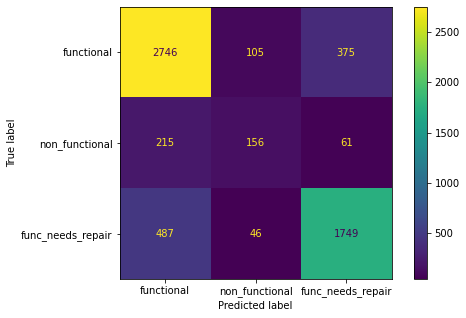

In [ ]:
print(classification_report(y_valid, AdaBoost_pred))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, AdaBoost_pred),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
adaboost_feature_scores = pd.Series(AdaBoost_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# adaboost_feature_scores

/usr/local/lib/python3.8/dist-packages/sklearn/tree/_classes.py:631: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


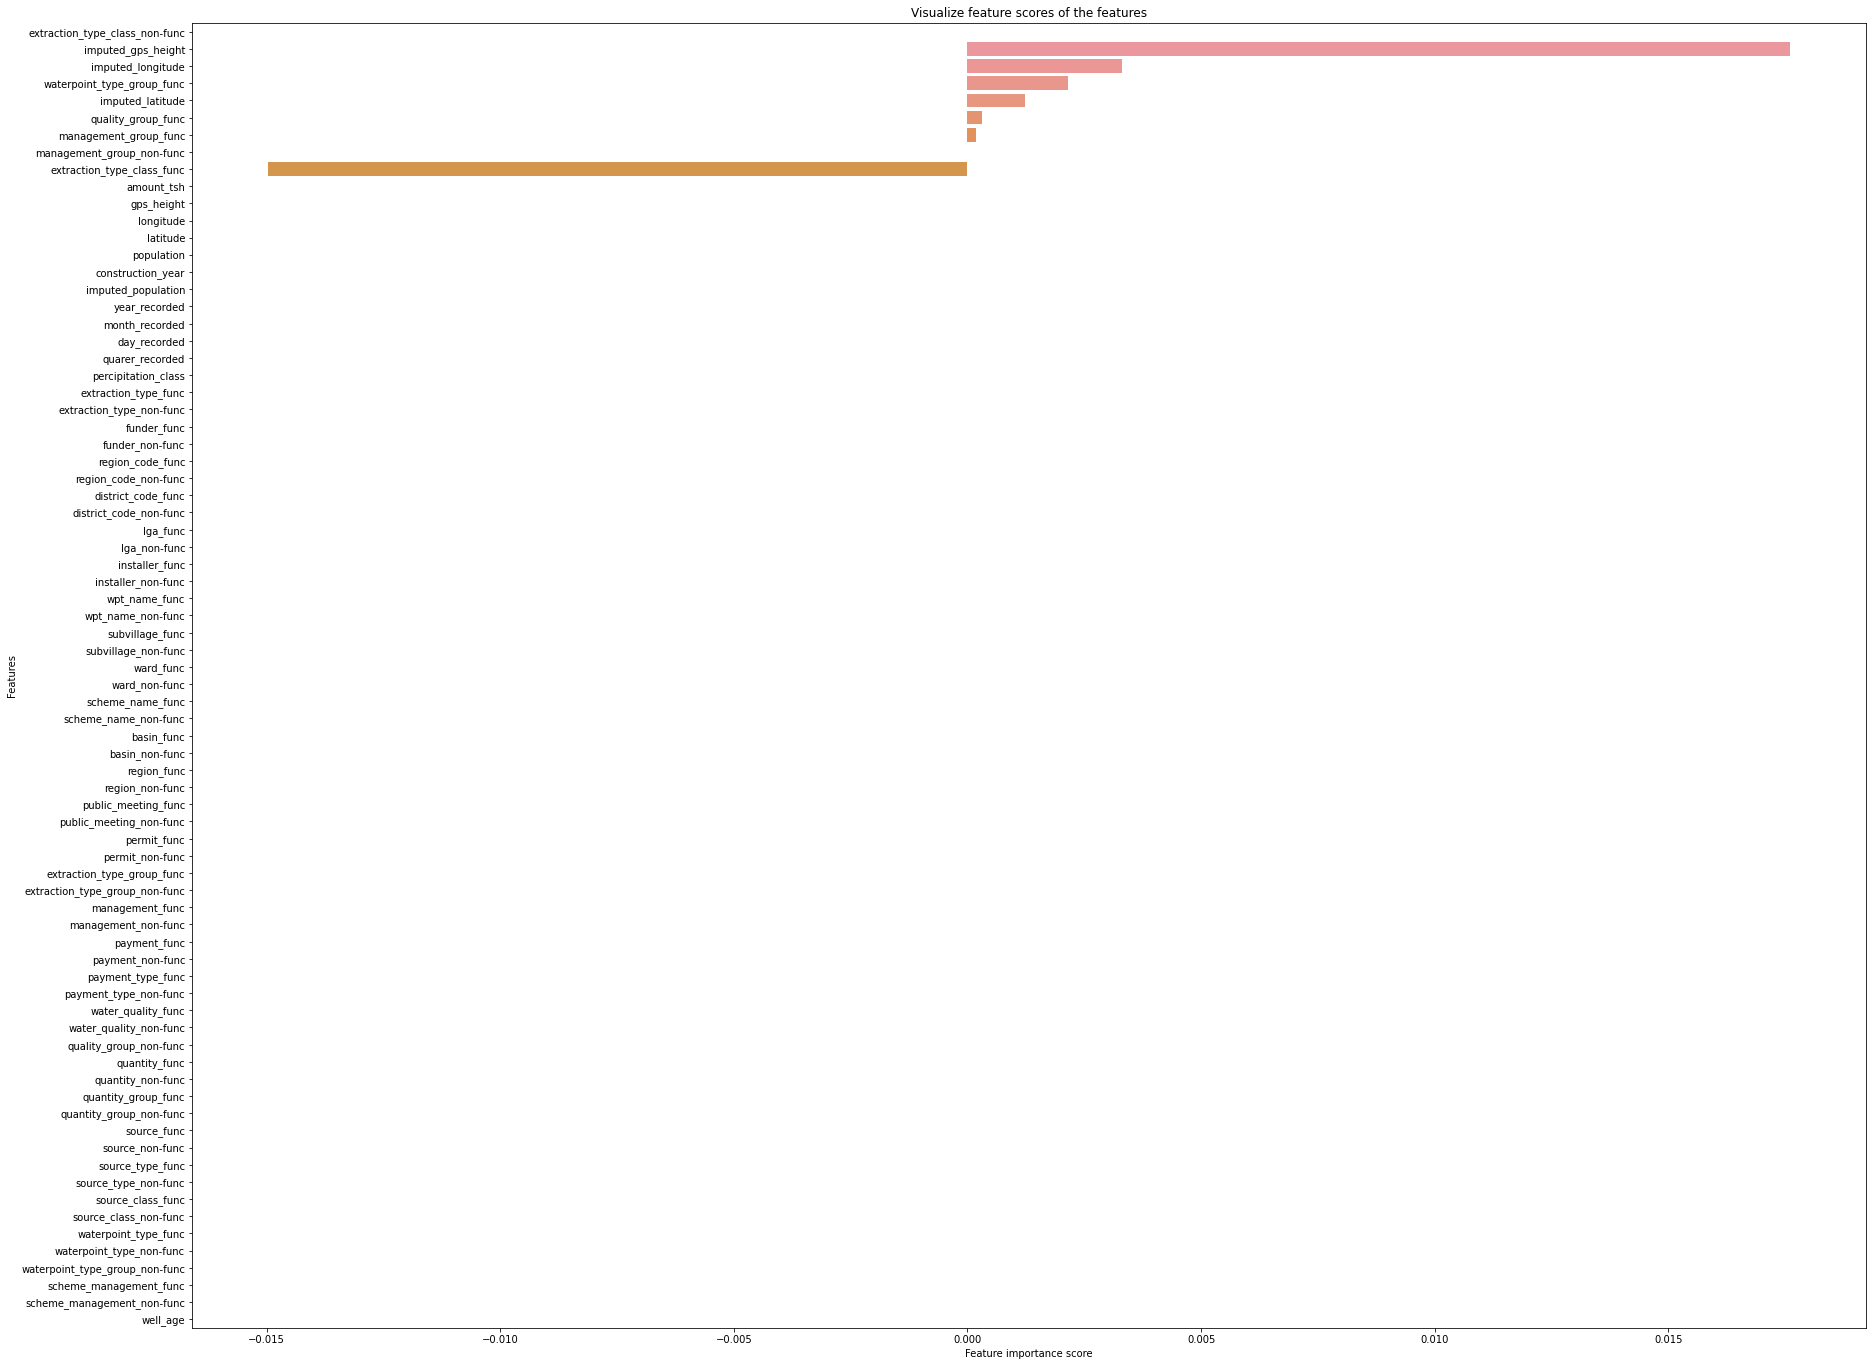

In [ ]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=adaboost_feature_scores, y=adaboost_feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(adaboost_feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

##4.1- Logistic regression

####Fit the Logistic regression model and Tune Hyperparameter

In [ ]:
lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(x_train, y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

* Hyperparameter Tuning

In [ ]:
params = {
    'alpha' : [0.001, 0.01, 0.1, 1.0, 10]
}
lr_hyperparam = GridSearchCV(lr_sgd, params, scoring='f1', cv=3, n_jobs = -1, verbose = 5, return_train_score = True)
lr_hyperparam.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     n_jobs=-1, penalty='elasticnet',
                                     random_state=42),
             n_jobs=-1, param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10]},
             return_train_score=True, scoring='f1', verbose=5)

In [ ]:
lr_hyperparam.best_params_

{'alpha': 0.001}

In [ ]:
lr_full = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_full.fit(x_train, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

####Perform Prediction and Display Results for Logistic regression




In [ ]:
lr_preds = lr_full.predict(x_valid)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.00      0.01      3226
           1       0.07      1.00      0.14       432
           2       0.00      0.00      0.00      2282

    accuracy                           0.07      5940
   macro avg       0.36      0.33      0.05      5940
weighted avg       0.55      0.07      0.01      5940



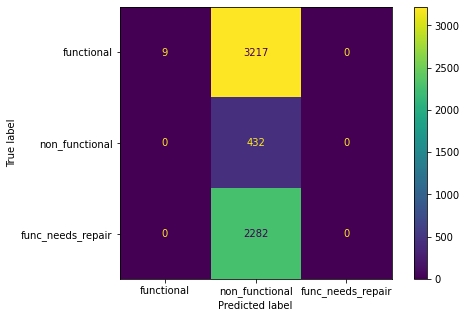

In [ ]:
print(classification_report(y_valid, lr_preds))

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_valid, lr_preds),
    display_labels=["functional", "non_functional", "func_needs_repair"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
lr_table = PrettyTable()
lr_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  # 'Log-loss'
                 ]

lr_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_valid, y_pred = lr_preds),
    f1_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    precision_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    recall_score(y_true = y_valid, y_pred = lr_preds, average='weighted'),
    # log_loss(y_true = y_valid, y_pred = lr_preds)
])
print(lr_table)

+---------------------+---------------------+----------------------+--------------------+---------------------+
|      Model Name     |       Accuracy      |       F1-Score       |     Precision      |        Recall       |
+---------------------+---------------------+----------------------+--------------------+---------------------+
| Logistic Regression | 0.07424242424242425 | 0.012897145753436019 | 0.5483949254814201 | 0.07424242424242425 |
+---------------------+---------------------+----------------------+--------------------+---------------------+


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####Feature Importances - Logistic Regression

<ipython-input-2925-98f99d594e09>:70: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
<ipython-input-2925-98f99d594e09>:71: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


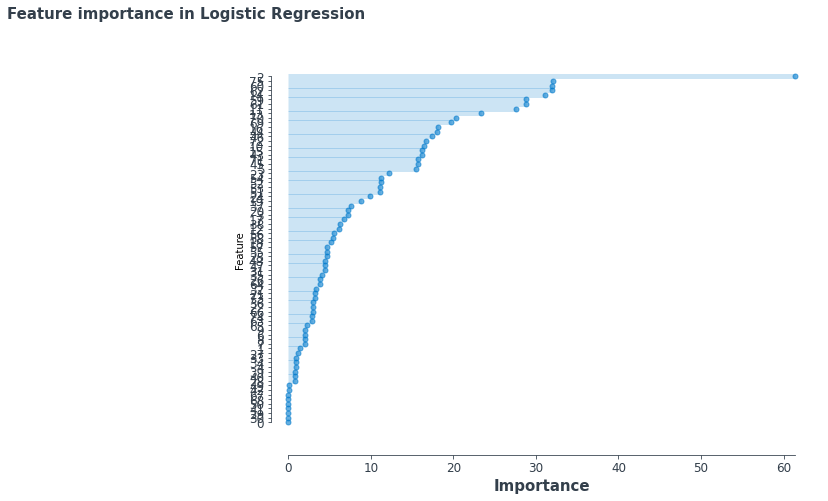

In [ ]:
pretty_importances_plot(
    np.abs(lr_full.coef_[0]), 
    [i for i in range(x_train.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)